  # Training on latent representations

# Setup

In [1]:
%load_ext autoreload  
%autoreload 2
from IPython.display import display, HTML, Image
from IPython.core.interactiveshell import InteractiveShell
display(HTML("<style>.container { width:98% !important; }</style>"))
InteractiveShell.ast_node_interactivity = "all"

In [2]:
import os
import sys
import csv
import json
import time
import types
import copy
import pprint
import logging
from datetime import datetime
for p in ['./src','../..']:
    if p not in sys.path:
        print(f"insert {p}")
        sys.path.insert(0, p)
print(sys.path)
# import shutil
# import getpass
# import yaml
# import hydra
# from hydra import initialize, initialize_config_module, initialize_config_dir, compose
# from omegaconf import OmegaConf
# from typing import Dict, List, Tuple
# from scipy.sparse import csr_matrix
# from tqdm import tqdm
# import wandb
from collections import defaultdict
from collections.abc import Iterator
import numpy as np
import pandas as pd
import scipy
import torch
import torch.nn.functional as F
from torchinfo import summary

torch.set_printoptions(precision=None, threshold=None, edgeitems=None, linewidth=150, profile=None, sci_mode=None)
pp = pprint.PrettyPrinter(indent=4)
pd.options.display.width = 132
torch.set_printoptions(precision=None, threshold=None, edgeitems=None, linewidth=150, profile=None, sci_mode=None)
np.set_printoptions(edgeitems=3, infstr='inf', linewidth=150, nanstr='nan')

os.environ["WANDB_NOTEBOOK_NAME"] = "AE-MAIN-SNNL.ipynb"
# os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
# os.environ["CUDA_VISIBLE_DEVICES"] = "2"

insert ./src
insert ../..
['../..', './src', '/home/kevin/WSL-shared/cellpainting/cj-datasets', '/home/kevin/miniforge3/envs/cp311/lib/python311.zip', '/home/kevin/miniforge3/envs/cp311/lib/python3.11', '/home/kevin/miniforge3/envs/cp311/lib/python3.11/lib-dynload', '', '/home/kevin/miniforge3/envs/cp311/lib/python3.11/site-packages', '/home/kevin/miniforge3/envs/cp311/lib/python3.11/site-packages/huggingface_hub-0.20.3-py3.8.egg']


In [3]:
# import snnl.utils as utils
# from snnl.utils import parse_args, load_configuration, set_global_seed, get_device, set_device
from KevinsRoutines.utils.utils_general import list_namespace, save_to_pickle, load_from_pickle
from utils.utils_cellpainting import compute_classification_metrics

/home/kevin/miniforge3/envs/cp311/lib/python3.11/site-packages/dask/dataframe/_pyarrow_compat.py:17: FutureWarning: Minimal version of pyarrow will soon be increased to 14.0.1. You are using 11.0.0. Please consider upgrading.
  warnings.warn(


In [4]:
import scipy.stats as sps
import sklearn.metrics as skm
from scipy.spatial.distance import pdist, squareform, euclidean
import matplotlib.pyplot as plt
import seaborn as sb
 
from sklearn.model_selection import train_test_split
import sklearn.utils.random as skr
import xgboost as xgb
# from sklearn.metrics import accuracy_score, f1_score, roc_curve, roc_auc_score, classification_report, precision_recall_fscore_support
# from sklearn.metrics import precision_recall_curve, PrecisionRecallDisplay, roc_curve, RocCurveDisplay
# from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [5]:
# Models
from xgboost import XGBClassifier, XGBRegressor

import sklearn.metrics as skm
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.svm import SVC, SVR
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor

# utility class to help normalize labels such that they contain only values between 0 and n_classes-1.
from sklearn.preprocessing import LabelEncoder

# K-Folds cross-validator - Provides train/test indices to split data in train/test sets. Split dataset into k consecutive folds (without shuffling by default).
# Each fold is then used once as a validation while the k - 1 remaining folds form the training set.
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.model_selection import GroupKFold, StratifiedGroupKFold
from sklearn.model_selection import ShuffleSplit, GroupShuffleSplit, StratifiedShuffleSplit, TimeSeriesSplit

# Evaluate metric(s) by cross-validation and also record fit/score times.
from sklearn.model_selection import cross_validate, cross_val_score

# Generate cross-validated estimates for each input data point.
# The data is split according to the cv parameter. Each sample belongs to exactly one test set,
# and its prediction is computed with an estimator fitted on the corresponding training set.
from sklearn.model_selection import cross_val_predict

# Exhaustive search over specified parameter values for an estimator.
# Randomized search on hyper parameters.
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# Input checker utility for building a cross-validator.(?)
from sklearn.model_selection._split import check_cv

from sklearn.pipeline import Pipeline

# Make a scorer from a performance metric or loss function. This factory function wraps scoring
# functions for use in GridSearchCV and cross_val_score. It takes a score function, such as accuracy_score,
# mean_squared_error, adjusted_rand_score or average_precision_score and returns a callable that
# scores an estimator’s output. The signature of the call is (estimator, X, y) where estimator
# is the model to be evaluated, X is the data and y is the ground truth labeling (or None in the
# case of unsupervised models).
from sklearn.metrics import make_scorer

# regression matrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# classification metrics
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# from sklearn.base import BaseEstimator
# from sklearn.base import ClassifierMixin
# from sklearn.base import TransformerMixin

# Construct a new unfitted estimator with the same parameters. Clone does a deep copy of the model
# in an estimator without actually copying attached data. It returns a new estimator with the same
# parameters that has not been fitted on any data.
# from sklearn.base import clone
from sklearn.preprocessing import StandardScaler


In [7]:
timestamp = datetime.now().strftime('%Y_%m_%d_%H:%M:%S')
logger = logging.getLogger(__name__)
logLevel = os.environ.get('LOG_LEVEL', 'INFO').upper()
FORMAT = '%(asctime)s - %(name)s - %(levelname)s: - %(message)s'
logging.basicConfig(level="INFO", format= FORMAT)

logger.info(f" Excution started : {timestamp} ")
logger.info(f" Pytorch version  : {torch.__version__}")
logger.info(f" Scipy version    : {scipy.__version__}") 
logger.info(f" Numpy version    : {np.__version__}")
logger.info(f" Pandas version   : {pd.__version__}  ")


2024-08-08 06:50:08,545 - __main__ - INFO: -  Excution started : 2024_08_08_06:50:08 
2024-08-08 06:50:08,546 - __main__ - INFO: -  Pytorch version  : 2.2.0
2024-08-08 06:50:08,548 - __main__ - INFO: -  Scipy version    : 1.11.4
2024-08-08 06:50:08,548 - __main__ - INFO: -  Numpy version    : 1.26.2
2024-08-08 06:50:08,549 - __main__ - INFO: -  Pandas version   : 2.2.0  


## Helper routines

In [8]:
# model selection (hyperparameter tuning)

def model_selection(model, params_grid, X, y,
                    scoring = None, 
                    cv=5, n_jobs=6, pre_dispatch = None,
                    GridSearch = True, n_iter=20,
                    refit = True, verbose = 0):
    """
    return the refitted model on the whole train data
    input:
    -----
    model:          model to be grid searched
    params_grid:    dictionary of hyperparms to grid search
    X, y:           obvious
    scoring:        scoring Strategy to evaluate the performance of the cross-validated model on the test set.
    cv:             cross-validation fold, integer specifies the number of folds in a (Stratified)KFold,
                    stratified is used if the estimator is a classifier and y is either binary or multiclass
    n_iter          Number of parameter settings that are sampled in RandomizedSearchCV.
                    n_iter trades off runtime vs quality of the solution.
    refit:          Refit an estimator using the best found parameters on the whole dataset.
    """
    print(f" verbose is {verbose}")
    if verbose > 0:
        print(f" params_grid: {params_grid}")
        print(f" scoring    : {scoring}     cv:  {cv}   n_jobs: {n_jobs}   gridsearch: {GridSearch}    n_iter: {n_iter}   refit: {refit}   ")
    if pre_dispatch is None:
        pre_dispatch = n_jobs
    if GridSearch :
        model_train = GridSearchCV(model, 
                                   params_grid, 
                                   cv=cv, 
                                   n_jobs=n_jobs,
                                   scoring = scoring, 
                                   pre_dispatch = pre_dispatch,
                                   refit = refit, 
                                   verbose = verbose)
    else:
        model_train = RandomizedSearchCV(model, 
                                         param_distributions = params_grid, 
                                         cv=cv, 
                                         n_jobs = n_jobs, 
                                         n_iter = n_iter,
                                         scoring=scoring,
                                         pre_dispatch = pre_dispatch,
                                         refit = refit, verbose = verbose)

    model_train.fit(X, y)

    print("Best parameters set found on development set:", model_train.best_params_ )
    print("Best score:", model_train.best_score_ )

    print("Grid scores on development set:")
    print()
    means = model_train.cv_results_['mean_test_score']
    stds = model_train.cv_results_['std_test_score']


    for mean, std, params in zip(means, stds, model_train.cv_results_['params']):
        print("%0.5f (+/-%0.03f) for %r" % (mean, std * 2, params))
    return model_train


In [9]:
def balance_datasets(X,y, ratio = 2, verbose = False):
    y = y.astype(np.uint8)
    neg_idxs = np.nonzero([y == 0])[1]
    pos_idxs = np.nonzero([y == 1])[1]
    pos_idxs = np.array(pos_idxs)
    # print(f"\n # Pos rows: {len(pos_idxs)}   # Neg rows: {len(neg_idxs)}  Total: {len(pos_idxs)+ len(neg_idxs)}")
    # print(f" # Pos compounds: {len(pos_idxs)//3}   # Neg compounds: {len(neg_idxs)//3}  total: {(len(pos_idxs) + len(neg_idxs))//3}")
    # print(f"\n pos indexes - len: {len(pos_idxs)}")
    # print( pos_idxs[:50])
    # print( pos_idxs[-50:])
    # print(f"\n neg indexes - len: {len(neg_idxs)}")
    # print(neg_idxs[:50])
    # print(neg_idxs[-50:])
    
    stepped_pos_idxs = [x for x in pos_idxs if x % 3 == 0]
    stepped_neg_idxs = [x for x in neg_idxs if x % 3 == 0]
    stepped_neg_idxs = np.array(stepped_neg_idxs)
    pos_counts = len(stepped_pos_idxs)
    neg_counts = len(stepped_neg_idxs)
    
    if verbose:
        print(f"\n # Pos counts: {pos_counts}    # Neg counts: {neg_counts}   Total: {pos_counts+neg_counts}")
        print(f"\n pos indexes - len: {pos_counts}")
        print(stepped_pos_idxs[:25])
        print(stepped_pos_idxs[-25:])
        print(f"\n neg indexes - len: {neg_counts}")
        print(stepped_neg_idxs[:25])
        print(stepped_neg_idxs[-25:])
        print()
    num_neg_samples = ratio * pos_counts
    
    print(f"\n Take {pos_counts} samples from total of {pos_counts} postive training samples")
    print(f" Take {num_neg_samples} samples from total of {neg_counts} negative training samples")
    sample_idxs = skr.sample_without_replacement(n_population=neg_counts, n_samples= num_neg_samples, )
    sample_idxs.sort()
    neg_sample_idxs = stepped_neg_idxs[sample_idxs]
    if verbose:
        print(f"\n Sample indxs - len: {len(sample_idxs)}")
        print(f" {sample_idxs[:20]}")
        print(f" {sample_idxs[-20:]}")
        print(f"\n neg_sample_idxs: {len(neg_sample_idxs)}")
        print(f"{neg_sample_idxs[:20]}")
        print(f"{neg_sample_idxs[-20:]}")
        print()
        print(neg_sample_idxs[:20])
        print(neg_sample_idxs[:20]+1)
        print(neg_sample_idxs[:20]+2)
    
    neg_sample_idxs_3 = np.concatenate((neg_sample_idxs, neg_sample_idxs+1, neg_sample_idxs+2))
    neg_sample_idxs_3.sort()
    if verbose:
        print(f"\n pos_sample_idxs_3: {len(pos_idxs)}")
        print(f" [:20] :{pos_idxs[:20]}")
        print(f" [-20:] {pos_idxs[-20:]}")
        print(f"\n neg_sample_idxs_3: {len(neg_sample_idxs_3)}")
        print(f" [:20] :{neg_sample_idxs_3[:20]}")
        print(f" [-20:] {neg_sample_idxs_3[-20:]}")
    
    balanced_ds_idxs = np.concatenate((pos_idxs, neg_sample_idxs_3))

    bal_X = X[balanced_ds_idxs]
    bal_y = y[balanced_ds_idxs]

    print(f"\n Balanced Dataset: # pos samples: {len(pos_idxs)}    # Neg samples: {len(neg_sample_idxs_3)}  Total len: {len(balanced_ds_idxs)}")   
    print(f"\n X :  Min: {bal_X.min():.4f}    Max: {bal_X.max():.4f}   Mean: {bal_X.mean():.4f}  Std: {bal_X.std():.4f}")
    print(f" y :  Min: {bal_y.min():.4f}    Max: {bal_y.max():.4f}   Mean: {bal_y.mean():.4f}  Std: {bal_y.std():.4f}")
    return bal_X,bal_y

In [10]:
def label_counts(input_list = None, title = None, label = None):
    if input_list is None:
        input_list = [(title, label)]

    for (ttl, lbl) in input_list:
        bcnt = np.bincount(lbl.astype(np.int64))
        bcnt_sum = bcnt.sum()
        print(f" {ttl}")
        print('','-'*(len(ttl)+1))
        print(f" Total samples: {bcnt_sum}  - compounds: {bcnt_sum//3}")
        print(f" Label 0: {bcnt[0]:7,d}      % {bcnt[0]*100/bcnt_sum:2.2f} ")
        print(f" Label 1: {bcnt[1]:7,d}      % {bcnt[1]*100/bcnt_sum:2.2f} ")
        print("")
        
def compute_metrics(true, pred, title = 'Classification Metrics'):
    test_accuracy = skm.accuracy_score(true, pred)
    # precision : tp / (tp+fp)
    precision, recall, f1, support = skm.precision_recall_fscore_support(true, pred, average='binary', zero_division=0)
    label_count = len(true)
    print(f" {title}")
    print('-'*(len(title)+2))
    print(f" Accuracy: {test_accuracy:.5f}     Precision: {precision:.5f}     Recall: {recall:.5f}     F1: {f1:.5f} \n"
          f"\n True + labels:        {true.sum():6.0f}     ratio to total:  {true.sum()/label_count:.5f}"
          f"\n Predicted + labels:   {pred.sum():6d}     ratio to total:  {pred.sum()/label_count:.5f}"
          f"\n True/Predicted Match: {(pred == true).sum():6d}     ratio to total:  {(pred==true).sum()/label_count:.5f}" )

def plots_from_estimator(estim, X, y):
    rows = 1
    cols = 3
    fig, axs = plt.subplots(1, cols, sharey=False, tight_layout=True, figsize=(cols *5,5))
    _ = skm.PrecisionRecallDisplay.from_estimator(estim, X, y, plot_chance_level = True, ax = axs[0])
    _ = skm.RocCurveDisplay.from_estimator(estim, X, y, plot_chance_level= True, ax = axs[1])
    _ = skm.ConfusionMatrixDisplay.from_estimator(estim, X, y, ax = axs[2])
    _ = axs[0].set_title(" Precision / Recall ")
    _ = axs[1].set_title(" ROC Curve ")
    plt.show()

def plots_from_predictions(true, pred):
    rows = 1
    cols = 3
    fig, axs = plt.subplots(1, cols, sharey=False, tight_layout=True, figsize=(cols *5,5) )
    _ = skm.PrecisionRecallDisplay.from_predictions(true, pred, plot_chance_level = True, ax = axs[0])
    _ = skm.RocCurveDisplay.from_predictions(true, pred, plot_chance_level= True, ax = axs[1])
    _ = skm.ConfusionMatrixDisplay.from_predictions(true, pred, ax = axs[2], values_format='d')
    _ = axs[0].set_title(" Precision / Recall ")
    _ = axs[1].set_title(" ROC Curve ")
    plt.show()

### main(args)

In [11]:
LATENT_DIM    = 150
HIDDEN_1      = 512
DATE          = 'yyyymmdd-hhmm'
EPOCHS        = 5
COMPOUNDS_PER_BATCH = 200
RUNMODE       = "snnl"
CONFIGURATION   = "./hyperparameters/ae_sn_150_512_cpb.yaml"
input_path = f"/home/kevin/WSL-shared/cellpainting/cj-datasets/output_11102023/3_sample_embeddings/"
output_path = f"./embedding_models/"

In [12]:
BASE_runmode = 'BASELINE'
base_date = "20240709"
base_time = "1950"
## SNNL
SNNL_runmode = 'SNNL'
snnl_date = "20240718"
snnl_time = "1956"
indicator = 'd'
##
ex_title = f"scpb{COMPOUNDS_PER_BATCH}-{LATENT_DIM}Ltnt"
ex_cpb = 200
suffix = '*'
epochs = 50

In [13]:
# = utils.load_model_from_ckpt(model, ex_mode, ex_timestamp, ex_title, epochs, ex_cpb, ex_factor )
input_file_cols = ['Metadata_Source', 'Metadata_Batch', 'Metadata_Plate', 'Metadata_Well', 'Metadata_JCP2022', 'Metadata_Hash', 'Metadata_Bin', 'Metadata_TPSA', 'Metadata_lnTPSA', 'Metadata_log10TPSA', 'Metadata_Permiation']
input_file_cols += [f'Feature_{x:03d}' for x in range(LATENT_DIM)]
print(len(input_file_cols))

BASE_BEST_INPUT_FILE = f"3sample_profiles_embedding_{len(input_file_cols)}_HashOrder_{{runmode}}_{base_date}_{base_time}_BEST_{{datatype}}.csv"
BASE_LAST_INPUT_FILE = f"3sample_profiles_embedding_{len(input_file_cols)}_HashOrder_{{runmode}}_{base_date}_{base_time}_LAST_{{datatype}}.csv"
SNNL_BEST_INPUT_FILE = f"3sample_profiles_embedding_{len(input_file_cols)}_HashOrder_{{runmode}}_{snnl_date}_{snnl_time}_BEST_{{datatype}}.csv"
SNNL_LAST_INPUT_FILE = f"3sample_profiles_embedding_{len(input_file_cols)}_HashOrder_{{runmode}}_{snnl_date}_{snnl_time}_LAST_{{datatype}}.csv"

print(BASE_BEST_INPUT_FILE)
print(SNNL_BEST_INPUT_FILE)

161
3sample_profiles_embedding_161_HashOrder_{runmode}_20240709_1950_BEST_{datatype}.csv
3sample_profiles_embedding_161_HashOrder_{runmode}_20240718_1956_BEST_{datatype}.csv


In [14]:
BASE_TRAIN_INPUT = os.path.join(input_path, BASE_BEST_INPUT_FILE.format(runmode = BASE_runmode ,datatype='train'))
BASE_TEST_INPUT  = os.path.join(input_path, BASE_BEST_INPUT_FILE.format(runmode = BASE_runmode ,datatype='test'))
SNNL_TRAIN_INPUT = os.path.join(input_path, SNNL_BEST_INPUT_FILE.format(runmode = SNNL_runmode ,datatype='train'))
SNNL_TEST_INPUT  = os.path.join(input_path, SNNL_BEST_INPUT_FILE.format(runmode = SNNL_runmode ,datatype='test'))
BASE_TRAIN_INPUT
BASE_TEST_INPUT 
SNNL_TRAIN_INPUT
SNNL_TEST_INPUT 

'/home/kevin/WSL-shared/cellpainting/cj-datasets/output_11102023/3_sample_embeddings/3sample_profiles_embedding_161_HashOrder_BASELINE_20240709_1950_BEST_train.csv'

'/home/kevin/WSL-shared/cellpainting/cj-datasets/output_11102023/3_sample_embeddings/3sample_profiles_embedding_161_HashOrder_BASELINE_20240709_1950_BEST_test.csv'

'/home/kevin/WSL-shared/cellpainting/cj-datasets/output_11102023/3_sample_embeddings/3sample_profiles_embedding_161_HashOrder_SNNL_20240718_1956_BEST_train.csv'

'/home/kevin/WSL-shared/cellpainting/cj-datasets/output_11102023/3_sample_embeddings/3sample_profiles_embedding_161_HashOrder_SNNL_20240718_1956_BEST_test.csv'

# Input 

## Read Embedded Features CSV file

In [15]:
df_test = pd.read_csv(BASE_TEST_INPUT )

In [16]:
df_test.info()
df_test.shape
df_test.columns

df_test.iloc[:5,:13]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34542 entries, 0 to 34541
Columns: 161 entries, Metadata_Source to Feature_149
dtypes: float64(154), int64(2), object(5)
memory usage: 42.4+ MB


(34542, 161)

Index(['Metadata_Source', 'Metadata_Batch', 'Metadata_Plate', 'Metadata_Well', 'Metadata_JCP2022', 'Metadata_Hash', 'Metadata_Bin',
       'Metadata_TPSA', 'Metadata_lnTPSA', 'Metadata_log10TPSA',
       ...
       'Feature_140', 'Feature_141', 'Feature_142', 'Feature_143', 'Feature_144', 'Feature_145', 'Feature_146', 'Feature_147',
       'Feature_148', 'Feature_149'],
      dtype='object', length=161)

,Metadata_Source,Metadata_Batch,Metadata_Plate,Metadata_Well,Metadata_JCP2022,Metadata_Hash,Metadata_Bin,Metadata_TPSA,Metadata_lnTPSA,Metadata_log10TPSA,Metadata_Permiation,Feature_000,Feature_001
0,source_11,Batch2,EC000046,K04,JCP2022_009278,7406361908543180200,8,62.78,4.139637,1.797821,0.0,0.111074,0.654536
1,source_11,Batch2,EC000063,K04,JCP2022_009278,7406361908543180200,8,62.78,4.139637,1.797821,0.0,0.391824,1.839582
2,source_9,20211013-Run14,GR00003281,J15,JCP2022_009278,7406361908543180200,8,62.78,4.139637,1.797821,0.0,0.885861,-0.195879
3,source_5,JUMPCPE-20210908-Run28_20210909_072022,AETJUM107,J10,JCP2022_045457,7406621140030190348,12,33.20,3.502550,1.521138,0.0,-0.573352,0.370054
4,source_11,Batch3,EC000139,G04,JCP2022_045457,7406621140030190348,12,33.20,3.502550,1.521138,0.0,1.058790,0.671953


In [17]:
test_y = df_test.iloc[:,10:11].to_numpy().ravel().astype(np.uint8)
test_y.sum()
test_y.shape, type(test_y), test_y.dtype
test_X = df_test.iloc[:,11:].to_numpy()
test_X.shape,type(test_X), test_X.dtype

4164

((34542,), numpy.ndarray, dtype('uint8'))

((34542, 150), numpy.ndarray, dtype('float64'))

In [18]:
df_train = pd.read_csv(BASE_TRAIN_INPUT)
# df_train = pd.read_csv(TRAIN_INPUT, nrows = 100 )
# df_train = pd.read_csv(TRAIN_INPUT, usecols = ['Metadata_Batch'])

In [19]:
df_train.shape
df_train.info()
df_train.iloc[:5,:16]

(312000, 161)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 312000 entries, 0 to 311999
Columns: 161 entries, Metadata_Source to Feature_149
dtypes: float64(154), int64(2), object(5)
memory usage: 383.2+ MB


,Metadata_Source,Metadata_Batch,Metadata_Plate,Metadata_Well,Metadata_JCP2022,Metadata_Hash,Metadata_Bin,Metadata_TPSA,Metadata_lnTPSA,Metadata_log10TPSA,Metadata_Permiation,Feature_000,Feature_001,Feature_002,Feature_003,Feature_004
0,source_1,Batch5_20221030,UL001793,M26,JCP2022_006020,-9223347314827979542,10,71.18,4.265212,1.852358,0.0,-0.433529,1.901938,-0.471324,-0.236380,-0.399238
1,source_10,2021_06_22_U2OS_48_hr_run8,Dest210622-143628,M04,JCP2022_006020,-9223347314827979542,10,71.18,4.265212,1.852358,0.0,0.287972,4.810249,-0.742543,-6.138022,0.784481
2,source_3,CP_31_all_Phenix1,B040603b,G13,JCP2022_006020,-9223347314827979542,10,71.18,4.265212,1.852358,0.0,0.300482,4.671577,2.248919,-0.744904,-2.491390
3,source_6,p211004CPU2OS48hw384exp031JUMP,110000295562,M08,JCP2022_058905,-9223229703754907651,13,58.65,4.071588,1.768268,0.0,-2.723187,0.867973,2.068558,1.482372,1.172988
4,source_3,CP_32_all_Phenix1,B40003aW,M08,JCP2022_058905,-9223229703754907651,13,58.65,4.071588,1.768268,0.0,0.474727,1.885489,0.450759,-1.726868,0.934264


In [20]:
train_y = df_train.iloc[:,10:11].to_numpy().ravel().astype(np.uint8)
train_y.sum()
train_y.shape, type(train_y), train_y.dtype

train_X = df_train.iloc[:,11:].to_numpy()
train_X.shape,type(train_X) ,train_X.dtype

37164

((312000,), numpy.ndarray, dtype('uint8'))

((312000, 150), numpy.ndarray, dtype('float64'))

In [21]:
312000+34542

346542

In [22]:
grouping_xy = np.arange(train_y.shape[0]) // 3
grouping_xy.shape
grouping_xy[:20]
grouping_xy[-20:]


(312000,)

array([0, 0, 0, 1, 1, 1, 2, 2, 2, 3, 3, 3, 4, 4, 4, 5, 5, 5, 6, 6])

array([103993, 103993, 103994, 103994, 103994, 103995, 103995, 103995, 103996, 103996, 103996, 103997, 103997, 103997, 103998, 103998, 103998,
       103999, 103999, 103999])

## Standardize inputs

In [23]:
print(f"Train_X :  Min: {train_X.min():.4f}    Max: {train_X.max():.4f}   Mean: {train_X.mean():.4f}  Std: {train_X.std():.4f}")
print(f"Test_X  :  Min: {test_X.min():.4f}    Max: {test_X.max():.4f}    Mean: {test_X.mean():.4f}  Std: {test_X.std():.4f}")

Train_X :  Min: -74.0316    Max: 106.9051   Mean: 0.0366  Std: 2.6223
Test_X  :  Min: -55.3790    Max: 75.7460    Mean: 0.0369  Std: 2.6056


In [24]:
# print(f"Train_X :  Min: {train_X.min():.4f}    Max: {train_X.max():.4f}   Mean: {train_X.mean():.4f}  Std: {train_X.std():.4f}")
# print(f"Test_X  :  Min: {test_X.min():.4f}    Max: {test_X.max():.4f}    Mean: {test_X.mean():.4f}  Std: {test_X.std():.4f}")

In [26]:
scaler = StandardScaler(copy = True)
train_X = scaler.fit_transform(train_X)
test_X = scaler.transform(test_X)

In [27]:
print("After Standard Scaler Transformation")
print(f"Train_X :  Min: {train_X.min():.4f}    Max: {train_X.max():.4f}   Mean: {train_X.mean():.4f}  Std: {train_X.std():.4f}")
print(f"Test_X  :  Min: {test_X.min():.4f}    Max: {test_X.max():.4f}    Mean: {test_X.mean():.4f}  Std: {test_X.std():.4f}")


After Standard Scaler Transformation
Train_X :  Min: -32.6722    Max: 26.2209   Mean: -0.0000  Std: 1.0000
Test_X  :  Min: -23.9580    Max: 29.4294    Mean: 0.0004  Std: 0.9889


In [28]:
label_counts([("Training", train_y), ("Test", test_y)])

 Training
 ---------
 Total samples: 312000  - compounds: 104000
 Label 0: 274,836      % 88.09 
 Label 1:  37,164      % 11.91 

 Test
 -----
 Total samples: 34542  - compounds: 11514
 Label 0:  30,378      % 87.95 
 Label 1:   4,164      % 12.05 



## Modify TPSA Threshold

In [269]:
train_y_72 = np.zeros_like(train_y)
train_y_72.shape[0]/3

104000.0

In [42]:
print(f"                  min           max           std          mean           median")
for x in ['TPSA', 'lnTPSA', 'log10TPSA']:
    print(f"{x:12s} {df_train[x].min():13.7f} {df_train[x].max():13.7f} {df_train[x].std():13.7f} {df_train[x].mean():13.7f} {df_train[x].median():13.7f}") 

df_train.TPSA.count()
df_train[df_train.TPSA >= THRESHOLD].TPSA.count()/df_train.TPSA.count()
df_train[df_train.TPSA < THRESHOLD].TPSA.count()/df_train.TPSA.count()


                  min           max           std          mean           median
TPSA             3.2400000  2834.6700000    32.8859880    73.6213196    71.3600000
lnTPSA           1.1755733     7.9496808     0.3917724     4.2261118     4.2677375
log10TPSA        0.5105450     3.4525025     0.1701446     1.8353770     1.8534548


116691

0.12232305833354758

0.8776769416664524

In [203]:
_tmp = df_train.Metadata_Permiation.value_counts()
_tmp[0], _tmp[1]

(274836, 37164)

In [264]:
for threshold in [68, 69, 70, 71, 72, 100]:
    _tmp = (df_train['Metadata_TPSA'] >= threshold).value_counts()
    print(f"\n TPSA threshold {threshold} \n Total samples: {_tmp.sum()}")
    print(f" Label 0: {_tmp[False]:>7d}      % {_tmp[False]*100/_tmp.sum():2.2f} ")
    print(f" Label 1: {_tmp[True]:>7d}      % {_tmp[True]*100/_tmp.sum():2.2f} ")


 TPSA threshold 68 
 Total samples: 312000
 Label 0:  138900      % 44.52 
 Label 1:  173100      % 55.48 

 TPSA threshold 69 
 Total samples: 312000
 Label 0:  144249      % 46.23 
 Label 1:  167751      % 53.77 

 TPSA threshold 70 
 Total samples: 312000
 Label 0:  149058      % 47.77 
 Label 1:  162942      % 52.23 

 TPSA threshold 71 
 Total samples: 312000
 Label 0:  154125      % 49.40 
 Label 1:  157875      % 50.60 

 TPSA threshold 72 
 Total samples: 312000
 Label 0:  160203      % 51.35 
 Label 1:  151797      % 48.65 

 TPSA threshold 100 
 Total samples: 312000
 Label 0:  274836      % 88.09 
 Label 1:   37164      % 11.91 


In [265]:
# fig, ax = plt.subplots(figsize=(4,4))
# fig.canvas.draw()  # Need to draw the figure to define renderer
# ax.set_title("AngleLabel example")
# # Plot two crossing lines and label each angle between them with the above
# center = (4.5, 650)
# p1 = [(2.5, 710), (6.0, 605)]
# p2 = [(3.0, 275), (5.5, 900)]
# line1, = ax.plot(*zip(*p1))
# line2, = ax.plot(*zip(*p2))
# point, = ax.plot(*center, marker="o")


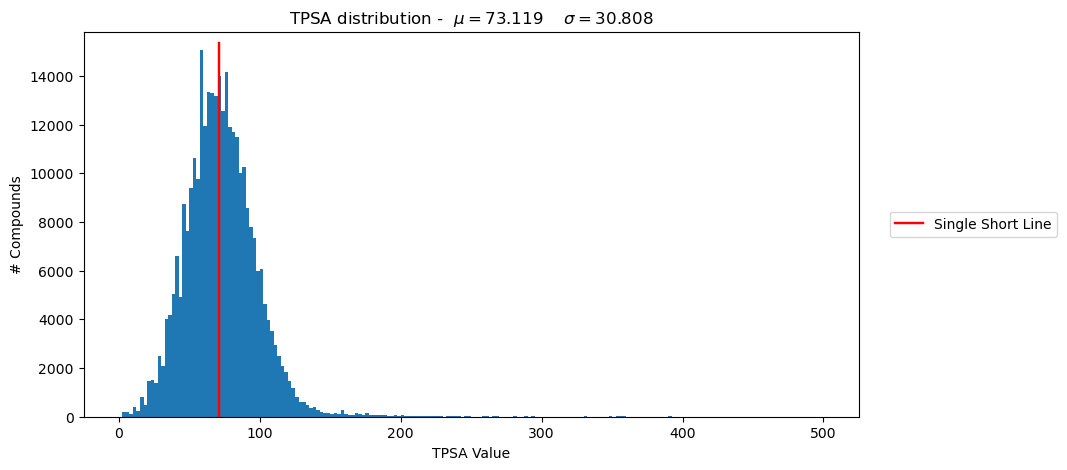

In [259]:
from matplotlib import colors
from matplotlib.ticker import PercentFormatter
num_bins = 200
# fig, ax = plt.subplots()
fig = plt.figure(figsize=(10,5))
sigma = df_train.Metadata_TPSA.std()
mu = df_train.Metadata_TPSA.mean()
med = df_train.Metadata_TPSA.median()
# the histogram of the data
# We can set the number of bins with the *bins* keyword argument.
n, bins, patches = plt.hist(df_train.Metadata_TPSA, num_bins, density=False, range=[0, 500],)
# p1 = [(med, 710), (6.0, 605)]
# _ = plt.vlines(x=med, ymin=10, ymax=17000, colors='red', linestyles='-', lw=1.75, label='Single Short Line')
_ = plt.axvline(x=med, ymin=0, ymax=.97, color='red', linestyle='-', lw=1.75, label='Single Short Line')
_ = plt.xlabel('TPSA Value');
_ = plt.ylabel('# Compounds');
_ = plt.title(fr'TPSA distribution -  $\mu={mu:.3f}$    $\sigma={sigma:.3f}$')
plt.legend(bbox_to_anchor=(1.04,0.5), loc="center left", borderaxespad=0)
# axs[1].hist(dist2, bins=n_bins)
plt.show()

## Stratified CV data splits

In [260]:
def visualize_groups(classes, groups, name):
    # Visualize dataset groups
    fig, ax = plt.subplots(figsize=(10,5))
    ax.scatter(
        range(len(groups)),
        [0.5] * len(groups),
        c=groups,
        marker="_",
        lw=50,
        cmap=cmap_data,
    )
    ax.scatter(
        range(len(groups)),
        [3.5] * len(groups),
        c=classes,
        marker="_",
        lw=50,
        cmap=cmap_data,
    )
    ax.set(
        ylim=[-1, 5],
        yticks=[0.5, 3.5],
        yticklabels=["Data\ngroup", "Data\nclass"],
        xlabel="Sample index",
    )

In [261]:
def plot_cv_indices(cv, X, y, group, ax, n_splits, lw=10):
    """Create a sample plot for indices of a cross-validation object."""
    use_groups = "Group" in type(cv).__name__
    groups = group if use_groups else None
    # Generate the training/testing visualizations for each CV split
    for ii, (tr, tt) in enumerate(cv.split(X=X, y=y, groups=groups)):
        # Fill in indices with the training/test groups
        indices = np.array([np.nan] * len(X))
        indices[tt] = 1
        indices[tr] = 0

        # Visualize the results
        ax.scatter(
            range(len(indices)),
            [ii + 0.5] * len(indices),
            c=indices,
            marker="_",
            lw=lw,
            cmap=cmap_cv,
            vmin=-0.2,
            vmax=1.2,
        )

    # Plot the data classes and groups at the end
    ax.scatter(
        range(len(X)), [ii + 1.5] * len(X), c=y, marker="_", lw=lw, cmap=cmap_data
    )

    ax.scatter(
        range(len(X)), [ii + 2.5] * len(X), c=group, marker="_", lw=lw, cmap=cmap_data
    )

    # Formatting
    yticklabels = list(range(n_splits)) + ["class", "group"]
    ax.set(
        yticks=np.arange(n_splits + 2) + 0.5,
        yticklabels=yticklabels,
        xlabel="Sample index",
        ylabel="CV iteration",
        ylim=[n_splits + 2.2, -0.2],
        xlim=[0, 100],
    )
    ax.set_title("{}".format(type(cv).__name__), fontsize=15)
    return ax

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Patch


In [ ]:
rng = np.random.RandomState(1338)
cmap_data = plt.cm.Paired
cmap_cv = plt.cm.coolwarm
n_splits = 4

# Generate the class/group data
# n_points = 100
# X = rng.randn(100, 10)

# percentiles_classes = [0.1, 0.3, 0.6]
# y = np.hstack([[ii] * int(100 * perc) for ii, perc in enumerate(percentiles_classes)])

In [ ]:
# Generate uneven groups

# group_prior = rng.dirichlet([2] * 10)
# group_prior.sum()
# group_prior

# groups = np.repeat(np.arange(10), rng.multinomial(100, group_prior))
# groups.shape
# groups

In [ ]:
groups = np.repeat(0, train_X.shape[0])
groups.shape

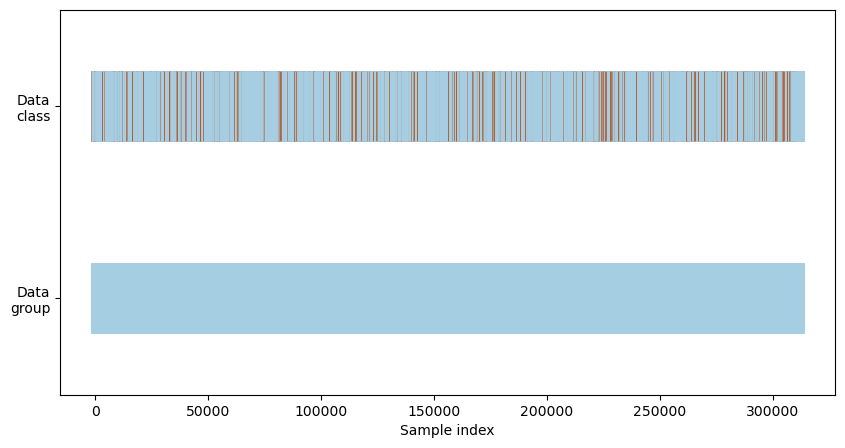

In [84]:
visualize_groups(train_y, groups, "no groups")

In [88]:
n_splits = 5
groups = None

/tmp/ipykernel_4107164/1298143750.py:29: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(


<Axes: title={'center': 'KFold'}, xlabel='Sample index', ylabel='CV iteration'>

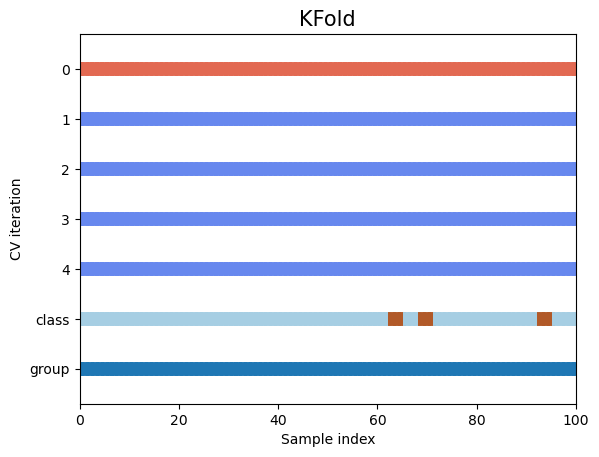

In [89]:
fig, ax = plt.subplots()
cv = KFold(n_splits)
plot_cv_indices(cv, train_X, train_y, groups, ax, n_splits)

## Create balanced datasets

In [29]:
bal_train_X, bal_train_y = balance_datasets(train_X, train_y, ratio = 1)
bal_test_X, bal_test_y = balance_datasets(test_X, test_y, ratio = 1)


 Take 12388 samples from total of 12388 postive training samples
 Take 12388 samples from total of 91612 negative training samples

 Balanced Dataset: # pos samples: 37164    # Neg samples: 37164  Total len: 74328

 X :  Min: -29.2645    Max: 22.2368   Mean: 0.0018  Std: 1.0081
 y :  Min: 0.0000    Max: 1.0000   Mean: 0.5000  Std: 0.5000

 Take 1388 samples from total of 1388 postive training samples
 Take 1388 samples from total of 10126 negative training samples

 Balanced Dataset: # pos samples: 4164    # Neg samples: 4164  Total len: 8328

 X :  Min: -18.0071    Max: 21.5709   Mean: 0.0035  Std: 0.9847
 y :  Min: 0.0000    Max: 1.0000   Mean: 0.5000  Std: 0.5000


In [30]:
bal_train_X_2, bal_train_y_2 = balance_datasets(train_X, train_y, ratio = 2)
bal_test_X_2, bal_test_y_2 = balance_datasets(test_X, test_y, ratio = 2)


 Take 12388 samples from total of 12388 postive training samples
 Take 24776 samples from total of 91612 negative training samples

 Balanced Dataset: # pos samples: 37164    # Neg samples: 74328  Total len: 111492

 X :  Min: -29.2645    Max: 24.8246   Mean: 0.0012  Std: 1.0109
 y :  Min: 0.0000    Max: 1.0000   Mean: 0.3333  Std: 0.4714

 Take 1388 samples from total of 1388 postive training samples
 Take 2776 samples from total of 10126 negative training samples

 Balanced Dataset: # pos samples: 4164    # Neg samples: 8328  Total len: 12492

 X :  Min: -19.7142    Max: 29.4294   Mean: 0.0015  Std: 1.0015
 y :  Min: 0.0000    Max: 1.0000   Mean: 0.3333  Std: 0.4714


In [31]:
bal_grouping_xy = np.arange(bal_train_y.shape[0]) // 3
bal_grouping_xy.shape
bal_grouping_xy[:20]
bal_grouping_xy[-20:]
bal_grouping_xy_2 = np.arange(bal_train_y_2.shape[0]) // 3
bal_grouping_xy_2.shape
bal_grouping_xy_2[:20]
bal_grouping_xy_2[-20:]

(74328,)

array([0, 0, 0, 1, 1, 1, 2, 2, 2, 3, 3, 3, 4, 4, 4, 5, 5, 5, 6, 6])

array([24769, 24769, 24770, 24770, 24770, 24771, 24771, 24771, 24772, 24772, 24772, 24773, 24773, 24773, 24774, 24774, 24774, 24775, 24775, 24775])

(111492,)

array([0, 0, 0, 1, 1, 1, 2, 2, 2, 3, 3, 3, 4, 4, 4, 5, 5, 5, 6, 6])

array([37157, 37157, 37158, 37158, 37158, 37159, 37159, 37159, 37160, 37160, 37160, 37161, 37161, 37161, 37162, 37162, 37162, 37163, 37163, 37163])

In [32]:
label_counts([("Training", train_y), ("Test", test_y)])
label_counts([("Balanced 1:1 Training", bal_train_y), ("Balanced 1:1 Test", bal_test_y)])
label_counts([("Balanced 1:2 Training", bal_train_y_2), ("Balanced 1:2 Test", bal_test_y_2)])

 Training
 ---------
 Total samples: 312000  - compounds: 104000
 Label 0: 274,836      % 88.09 
 Label 1:  37,164      % 11.91 

 Test
 -----
 Total samples: 34542  - compounds: 11514
 Label 0:  30,378      % 87.95 
 Label 1:   4,164      % 12.05 

 Balanced 1:1 Training
 ----------------------
 Total samples: 74328  - compounds: 24776
 Label 0:  37,164      % 50.00 
 Label 1:  37,164      % 50.00 

 Balanced 1:1 Test
 ------------------
 Total samples: 8328  - compounds: 2776
 Label 0:   4,164      % 50.00 
 Label 1:   4,164      % 50.00 

 Balanced 1:2 Training
 ----------------------
 Total samples: 111492  - compounds: 37164
 Label 0:  74,328      % 66.67 
 Label 1:  37,164      % 33.33 

 Balanced 1:2 Test
 ------------------
 Total samples: 12492  - compounds: 4164
 Label 0:   8,328      % 66.67 
 Label 1:   4,164      % 33.33 



# XGBoost Model - Param grid search using scikit

## **[XGBoost](https://xgboost.readthedocs.io/en/stable/python/sklearn_estimator.html)**

In [169]:
# clf = xgb.XGBClassifier(tree_method="hist", callbacks=[early_stop])
# xgb_clf = xgb.XGBClassifier(tree_method="hist", early_stopping_rounds=2)
xgb_clf = xgb.XGBClassifier(tree_method="hist")


## Parameters

In [200]:
# xgb_grid_parameters_0 = [
#   {'C': [0.01, 0.1, 1, 10, 100, 200, 400, 1000], 'kernel': ['linear']},
#   {'C': [0.01, 0.1, 1, 10, 100, 200, 400, 1000], 'kernel': ['rbf']},
#   {'C': [0.01, 0.1, 1, 10, 100, 200, 400, 1000], 'gamma': [100,10,1,1e-1,1e-2, 1e-3], 'kernel': ['rbf']},
#  ]

# xgb_grid_parameters_1 = {'C': [1, 10], 'gamma': [1,1e-1], 'kernel' : ['linear'] }
# xgb_grid_parameters_1 = {'C': [1], 'gamma': [1e-1], 'kernel' : ['linear'] }
# xgb_grid_parameters_2 = {'C': [1, 10], 'kernel': ['linear']}
# xgb_grid_parameters_2 = {'C': [1, 10], 'gamma': [1,1e-1], 'kernel': ['rbf']}
# xgb_grid_parameters_3 = { 'C': [1, 10, 100],'gamma': [10,1,1e-1,1e-2]}
# xgb_grid_parameters_3 = { 'C': [1, 10, 100], 'kernel': ['rbf']}
# xgb_grid_parameters_3 = { 'C': [10], 'kernel': ['rbf'],'gamma': [  1, 1.0e-1, 1.0e-2, ]}
# xgb_grid_parameters_3 = { 'C': [10], 'kernel': ['rbf'],'gamma': [  1.0e-3, 1.0e-4, 1.0e-5, ]}
# xgb_grid_parameters_3 = { 'C': [10], 'kernel': ['rbf'],'gamma': [1.0e-6, 1.0e-7, 1.0e-8,]}
# xgb_grid_parameters_3 = {'C': [0.1, 1, 10, 100, 200], 'kernel': ['rbf']}
xgb_grid_parameters_3 = {"n_estimators" : [25, 50, 75, 100], "learning_rate"  : [1.0e-01, 1,10]}
xgb_grid_parameters_3 = {"n_estimators"  : [ 75, 100, 150] , "learning_rate"  : [1.0e-01, 1 , 10],  "max_depth" : [2,4 ],  "max_leaves" : [2], }
xgb_grid_parameters_3 = {"n_estimators"      : [ 150, 250] , 
                         "max_depth"         : [  2,  5] ,  
                         "max_leaves"        : [  0,  4,  6],
                         "learning_rate"     : [1.0e-1, 1, 10, 100],
                         "lambda"            : [1.0e-1, 1, 10, 100]
                         # "learning_rate"     : [0.013455,  0.85865],
                         # "min_split_loss"    : [4.74917,  3.60513],
                         # "max_depth"         : [13.0000,  10.00000],
                         # "min_child_weight"  : [4.00851,  9.58354],
                         # "max_delta_step"    : [1.08196,  2.11724],
                         # "subsample"         : [0.71916,  0.88346],
                         # "colsample_bylevel" : [0.94740,  0.61197],
                         # "colsample_bynode"  : [0.65944,  0.85980],
                        }

In [290]:
sgkf.__dict__

{'n_splits': 5, 'shuffle': False, 'random_state': None}

In [252]:
for i, j in enumerate(CV_SCHEME):
    print(i, type(j))

<generator object _BaseKFold.split at 0x7f5f25f0f640>

0 <class 'tuple'>
1 <class 'tuple'>
2 <class 'tuple'>
3 <class 'tuple'>
4 <class 'tuple'>


In [255]:
j = next(CV_SCHEME)

In [263]:
CV_SCHEME = sgkf.split(X_DATA, Y_DATA, GRP_DATA)

i = 0
<class 'numpy.ndarray'> 59460


array([ 3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 18, 19, 20, 21, 22, 23, 24, 25])

array([74302, 74303, 74304, 74305, 74306, 74307, 74308, 74309, 74313, 74314, 74315, 74316, 74317, 74318, 74319, 74320, 74321, 74322, 74323, 74324])

(numpy.ndarray, 14868)

array([ 0,  1,  2, 15, 16, 17, 30, 31, 32, 45, 46, 47, 60, 61, 62, 75, 76, 77, 90, 91])

array([74236, 74237, 74250, 74251, 74252, 74265, 74266, 74267, 74280, 74281, 74282, 74295, 74296, 74297, 74310, 74311, 74312, 74325, 74326, 74327])




i = 1
<class 'numpy.ndarray'> 59463


array([ 0,  1,  2,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 21, 22, 23, 24, 25])

array([74305, 74306, 74307, 74308, 74309, 74310, 74311, 74312, 74316, 74317, 74318, 74319, 74320, 74321, 74322, 74323, 74324, 74325, 74326, 74327])

(numpy.ndarray, 14865)

array([ 3,  4,  5, 18, 19, 20, 33, 34, 35, 48, 49, 50, 63, 64, 65, 78, 79, 80, 93, 94])

array([74224, 74225, 74238, 74239, 74240, 74253, 74254, 74255, 74268, 74269, 74270, 74283, 74284, 74285, 74298, 74299, 74300, 74313, 74314, 74315])




i = 2
<class 'numpy.ndarray'> 59463


array([ 0,  1,  2,  3,  4,  5,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 24, 25])

array([74305, 74306, 74307, 74308, 74309, 74310, 74311, 74312, 74313, 74314, 74315, 74319, 74320, 74321, 74322, 74323, 74324, 74325, 74326, 74327])

(numpy.ndarray, 14865)

array([ 6,  7,  8, 21, 22, 23, 36, 37, 38, 51, 52, 53, 66, 67, 68, 81, 82, 83, 96, 97])

array([74227, 74228, 74241, 74242, 74243, 74256, 74257, 74258, 74271, 74272, 74273, 74286, 74287, 74288, 74301, 74302, 74303, 74316, 74317, 74318])




i = 3
<class 'numpy.ndarray'> 59463


array([ 0,  1,  2,  3,  4,  5,  6,  7,  8, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22])

array([74302, 74303, 74307, 74308, 74309, 74310, 74311, 74312, 74313, 74314, 74315, 74316, 74317, 74318, 74322, 74323, 74324, 74325, 74326, 74327])

(numpy.ndarray, 14865)

array([  9,  10,  11,  24,  25,  26,  39,  40,  41,  54,  55,  56,  69,  70,  71,  84,  85,  86,  99, 100])

array([74230, 74231, 74244, 74245, 74246, 74259, 74260, 74261, 74274, 74275, 74276, 74289, 74290, 74291, 74304, 74305, 74306, 74319, 74320, 74321])




i = 4
<class 'numpy.ndarray'> 59463


array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 15, 16, 17, 18, 19, 20, 21, 22])

array([74302, 74303, 74304, 74305, 74306, 74310, 74311, 74312, 74313, 74314, 74315, 74316, 74317, 74318, 74319, 74320, 74321, 74325, 74326, 74327])

(numpy.ndarray, 14865)

array([ 12,  13,  14,  27,  28,  29,  42,  43,  44,  57,  58,  59,  72,  73,  74,  87,  88,  89, 102, 103])

array([74233, 74234, 74247, 74248, 74249, 74262, 74263, 74264, 74277, 74278, 74279, 74292, 74293, 74294, 74307, 74308, 74309, 74322, 74323, 74324])

## Training

In [250]:
PARM_SET = xgb_grid_parameters_3

In [201]:
sgkf = StratifiedGroupKFold(n_splits = 5,)

In [254]:
NUM_JOBS = 5
X_DATA = bal_train_X
Y_DATA = bal_train_y
GRP_DATA = bal_grouping_xy
CV_SCHEME = sgkf.split(X_DATA, Y_DATA, GRP_DATA)

In [204]:
vt_xgb = model_selection(xgb_clf, PARM_SET, X_DATA, Y_DATA, scoring = 'roc_auc', cv=CV_SCHEME, GridSearch = True, n_jobs=NUM_JOBS,  verbose = 1)

 verbose is 1
 params_grid: {'n_estimators': [150, 250], 'max_depth': [2, 5], 'max_leaves': [0, 4, 6], 'learning_rate': [0.1, 1, 10, 100], 'lambda': [0.1, 1, 10, 100]}
 scoring    : roc_auc     cv:  <generator object _BaseKFold.split at 0x7f5f5852cca0>   n_jobs: 5   gridsearch: True    n_iter: 20   refit: True   
Fitting 5 folds for each of 192 candidates, totalling 960 fits
Best parameters set found on development set: {'lambda': 100, 'learning_rate': 0.1, 'max_depth': 5, 'max_leaves': 0, 'n_estimators': 250}
Best score: 0.6015185598233024
Grid scores on development set:

0.59374 (+/-0.007) for {'lambda': 0.1, 'learning_rate': 0.1, 'max_depth': 2, 'max_leaves': 0, 'n_estimators': 150}
0.59729 (+/-0.008) for {'lambda': 0.1, 'learning_rate': 0.1, 'max_depth': 2, 'max_leaves': 0, 'n_estimators': 250}
0.59374 (+/-0.007) for {'lambda': 0.1, 'learning_rate': 0.1, 'max_depth': 2, 'max_leaves': 4, 'n_estimators': 150}
0.59729 (+/-0.008) for {'lambda': 0.1, 'learning_rate': 0.1, 'max_depth': 2

#### results 

In [197]:
vt_xgb.best_index_
vt_xgb.best_params_
vt_xgb.best_score_
vt_xgb.best_estimator_
# vt_xgb
# vt_xgb.estimator
# vt_xgb.cv_results_
# vt_xgb.fit


23

{'lambda': 0.1,
 'learning_rate': 0.2,
 'max_depth': 5,
 'max_leaves': 6,
 'n_estimators': 250}

0.5997383059677766

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, lambda=0.1, learning_rate=0.2,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=6,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=250, n_jobs=None,
              num_parallel_tree=None, ...)

In [195]:
# print('-'*40)
# print(f"vt_xgb parameters: ")
# print('-'*40)
# vt_xgb.get_params()
# vt_xgb.classes_
# vt_xgb.cv
# cv_list = [ x for x in vt_xgb.cv]
# vt_xgb.multimetric_
# vt_xgb.n_features_in_
# vt_xgb.n_jobs
# vt_xgb.n_splits_
# vt_xgb.param_grid
# vt_xgb.pre_dispatch
# vt_xgb.predict
# vt_xgb.predict_log_proba
# vt_xgb.predict_proba
# vt_xgb.refit
# vt_xgb.refit_time_
# vt_xgb.return_train_score
# vt_xgb.score
# vt_xgb.score_samples
# vt_xgb.scorer_
# vt_xgb.scoring
# vt_xgb.transform
# vt_svm.verbose

In [ ]:
Balanced data
{'lambda': 0.1, 'learning_rate': 0.2, 'max_depth': 5, 'max_leaves': 6, 'n_estimators': 250}
0.5997383059677766

Imbalanced data:
#### Best score: 0.589562942908825
Grid scores on development set:
0.60383 (+/-0.013) for {'learning_rate': 0.1, 'max_depth': 5, 'max_leaves': 0, 'n_estimators': 250}
Grid scores on development set:                 
0.60486 (+/-0.008) for {'learning_rate': 0.1, 'max_depth': 4, 'max_leaves': 0, 'n_estimators': 250}


## Save / Load Model

In [34]:
FILENAME = 'XGB_estimators_BASE_1_UNBALANCED.pkl'
SAVE_MODEL = os.path.join(output_path, FILENAME)
SAVE_MODEL

'./embedding_models/XGB_estimators_BASE_1_UNBALANCED.pkl'

In [642]:
save_to_pickle(vt_svm, '', FILENAME, verbose = True)

 save_to_pickle(): save data to SVM_estimators_SNNL_1_BALANCED_RATIO_1.pkl


### Load Model

In [35]:
FILENAME = 'XGB_estimators_BASE_1_UNBALANCED.pkl'
LOAD_MODEL = os.path.join(output_path, FILENAME)
LOAD_MODEL

'./embedding_models/XGB_estimators_BASE_1_UNBALANCED.pkl'

In [447]:
svm_estimators = load_from_pickle('', FILENAME)

In [448]:
svm_estimators
print(f"parameters   :")
# pp.pprint(svm_estimators.get_params())
print()
# print(f"best_estimator_  :   {svm_estimators.best_estimator_}")
# print(f"best_index_  :       {svm_estimators.best_index_}")
# print(f"best_params_ :       {svm_estimators.best_params_}")
# print(f"best_score_  :       {svm_estimators.best_score_}")
# print(f"classes_     :       {svm_estimators.classes_}")
# print(f"cv           :       {svm_estimators.cv}")
# print()
# print(f"cv_results_  :       {svm_estimators.cv_results_}")
# print()
# print(f"error_score  :       {svm_estimators.error_score}")
# print(f"estimator    :       {svm_estimators.estimator}")

GridSearchCV(cv=4,
             estimator=SVC(cache_size=400, class_weight='balanced',
                           max_iter=10000, random_state=42, tol=1e-05),
             n_jobs=5,
             param_grid={'C': [0.1, 1, 10, 100, 200], 'kernel': ['rbf']},
             pre_dispatch=5, scoring='roc_auc', verbose=3)

parameters   :

best_estimator_  :   SVC(C=0.1, cache_size=400, class_weight='balanced', max_iter=10000,
    random_state=42, tol=1e-05)


## Results

In [124]:
# vt_xgb
vt_xgb.estimator
vt_xgb.best_estimator_
vt_xgb.best_index_
vt_xgb.best_params_
vt_xgb.best_score_
 

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=0,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=250, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

6

{'learning_rate': 0.1, 'max_depth': 5, 'max_leaves': 0, 'n_estimators': 250}

0.6038250326380945

## Persist / Load Model

In [134]:
SAVE_MODEL_FILENAME = 'XGB_estimators_BASE_1_UNBALANCED.pkl'
SAVE_FILENAME = os.path.join(output_path, SAVE_MODEL_FILENAME)
SAVE_FILENAME
# vt_xgb.cv = None

'./embedding_models/XGB_estimators_BASE_1_UNBALANCED.pkl'

In [135]:
save_to_pickle(vt_xgb, '', SAVE_FILENAME, verbose = True)

 save_to_pickle(): save data to ./embedding_models/XGB_estimators_BASE_1_UNBALANCED.pkl


## Load Model

In [139]:
xgb_estimator = load_from_pickle('', SAVE_FILENAME)

In [140]:
xgb_estimator
print(f"parameters   :")
# pp.pprint(xgb_estimator.get_params())
print()
print(f"best_estimator_  :   {xgb_estimator.best_estimator_}")
# print(f"best_index_  :       {xgb_estimator.best_index_}")
# print(f"best_params_ :       {xgb_estimator.best_params_}")
# print(f"best_score_  :       {xgb_estimator.best_score_}")
# print(f"classes_     :       {xgb_estimator.classes_}")
# print(f"cv           :       {xgb_estimator.cv}")
# print()
# print(f"cv_results_  :       {xgb_estimator.cv_results_}")
# print()
# print(f"error_score  :       {xgb_estimator.error_score}")
# print(f"estimator    :       {xgb_estimator.estimator}")

GridSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_b...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             n_jobs=5,
             param_grid={'learning_rate': [0.1, 0.2, 0.3],
                         'max_depth': [2, 5, 10], 'max_leaves': [0, 4, 6],
                         'n_estimators': [250, 350]},
             pre_dispatch=5, scoring='roc_auc', verbose=3)

parameters   :

best_estimator_  :   XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=0,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=250, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)


# Metrics - 0 

In [151]:
# print(f"parameters   :")
# pp.pprint(xgb_estimator.get_params())
print(f"best_estimator_  :   {xgb_estimator.best_estimator_}")
print()
 

best_estimator_  :   XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=0,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=250, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)



In [152]:
# TEST_X, TEST_Y = bal_test_X, bal_test_y
TEST_X, TEST_Y = test_X, test_y

In [153]:
y_pred = xgb_estimator.best_estimator_.predict(TEST_X)
y_pred.shape

(34542,)

In [154]:
bal_y_pred = xgb_estimator.best_estimator_.predict(bal_test_X)
bal_y_pred.shape

(8328,)

In [155]:
label_counts( [("Ground Truth", test_y), ("Predictions", y_pred), ("Balanced Ground Truth", bal_test_y), ("Balanced Predictions", bal_y_pred)])

 Ground Truth
 Total samples: 34542
 Label 0:  30,378      % 87.95 
 Label 1:   4,164      % 12.05 

 Predictions
 Total samples: 34542
 Label 0:  34,525      % 99.95 
 Label 1:      17      % 0.05 

 Balanced Ground Truth
 Total samples: 8328
 Label 0:   4,164      % 50.00 
 Label 1:   4,164      % 50.00 

 Balanced Predictions
 Total samples: 8328
 Label 0:   8,322      % 99.93 
 Label 1:       6      % 0.07 



In [158]:
compute_metrics(test_y, y_pred, "Original test file")

 Original test file
--------------------
 Accuracy: 0.87931     Precision: 0.35294     Recall: 0.00144     F1: 0.00287 

 True + labels:          4164     ratio to total:  0.12055
 Predicted + labels:       17     ratio to total:  0.00049
 True/Predicted Match:  30373     ratio to total:  0.87931


In [159]:
compute_metrics(bal_test_y, bal_y_pred, " 1:1 Balanced test file")

  1:1 Balanced test file
-------------------------
 Accuracy: 0.50072     Precision: 1.00000     Recall: 0.00144     F1: 0.00288 

 True + labels:          4164     ratio to total:  0.50000
 Predicted + labels:        6     ratio to total:  0.00072
 True/Predicted Match:   4170     ratio to total:  0.50072


In [662]:
# plots_from_estimator(xgb_estimator.best_estimator_, test_X, y_pred)
# plots_from_estimator(xgb_estimator.best_estimator_, bal_test_X, bal_y_pred)

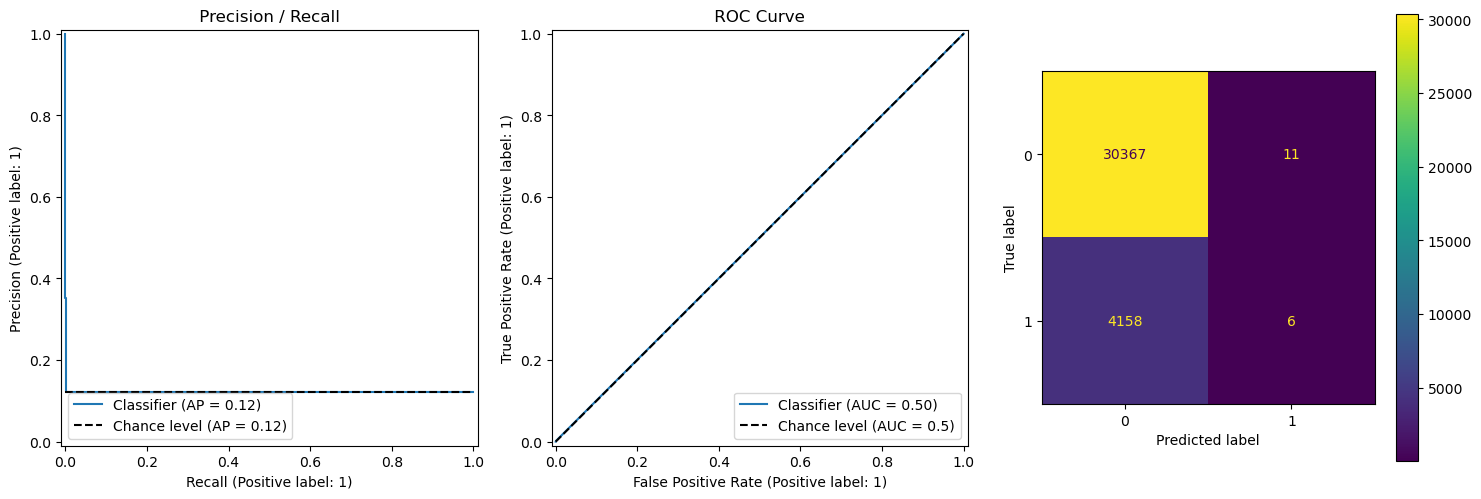

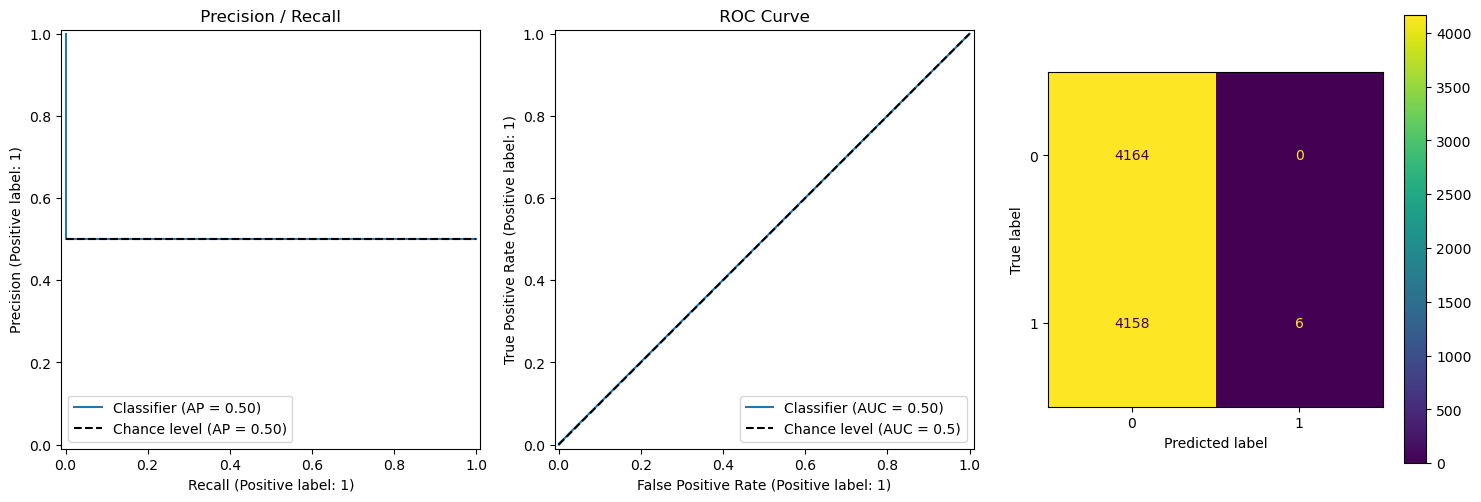

In [160]:
plots_from_predictions(test_y, y_pred)
plots_from_predictions(bal_test_y, bal_y_pred)

# Metrics - 1

In [303]:
FILENAME = 'KNN_estimators_1.pkl'

In [304]:
knn_estimators = load_from_pickle('', FILENAME)
knn_estimators
# print(f"parameters   :")
# pp.pprint(knn_estimators.get_params())
# print()
print(f"best_estimator_  :   {knn_estimators.best_estimator_}")
 

GridSearchCV(cv=5, estimator=KNeighborsClassifier(), n_jobs=4,
             param_grid={'metric': ['minkowski'],
                         'n_neighbors': [57, 69, 81, 90], 'p': [2],
                         'weights': ['distance']},
             scoring='roc_auc', verbose=1)

best_estimator_  :   KNeighborsClassifier(n_neighbors=90, weights='distance')


In [307]:
y_pred = knn_estimators.best_estimator_.predict(test_X)
y_pred.shape

(34542,)

In [309]:
for grp_name, labels in [("Ground Truth", test_y), ("Predictions", y_pred)]:
    bcnt = np.bincount(labels.astype(np.int64))
    print(f" {grp_name}")
    print(f" Total samples: {bcnt.sum():7,d}")
    print(f" Label 0: {bcnt[0]:7,d}      % {bcnt[0]*100/bcnt.sum():2.2f} ")
    print(f" Label 1: {bcnt[1]:7,d}      % {bcnt[1]*100/bcnt.sum():2.2f} ")
    print("")

 Ground Truth
 Total samples:  34,542
 Label 0:  30,378      % 87.95 
 Label 1:   4,164      % 12.05 

 Predictions
 Total samples:  34,542
 Label 0:  34,532      % 99.97 
 Label 1:      10      % 0.03 



In [311]:
test_accuracy = skm.accuracy_score(test_y, y_pred)
precision, recall, f1, support = skm.precision_recall_fscore_support(test_y, y_pred, average='binary', zero_division=0)

print(f" Test Accuracy: {test_accuracy:4f}")
print(f" Precision: {precision:.5f}     Recall: {recall:.5f}     F1: {f1:.5f} "
      f"\n True + labels: {test_y.sum()}  Predicted + labels: {y_pred.sum()}     Match: {(y_pred == test_y).sum()} " )

 Test Accuracy: 0.879567
 Precision: 0.70000     Recall: 0.00168     F1: 0.00335 
 True + labels: 4164.0  Predicted + labels: 10.0     Match: 30382 


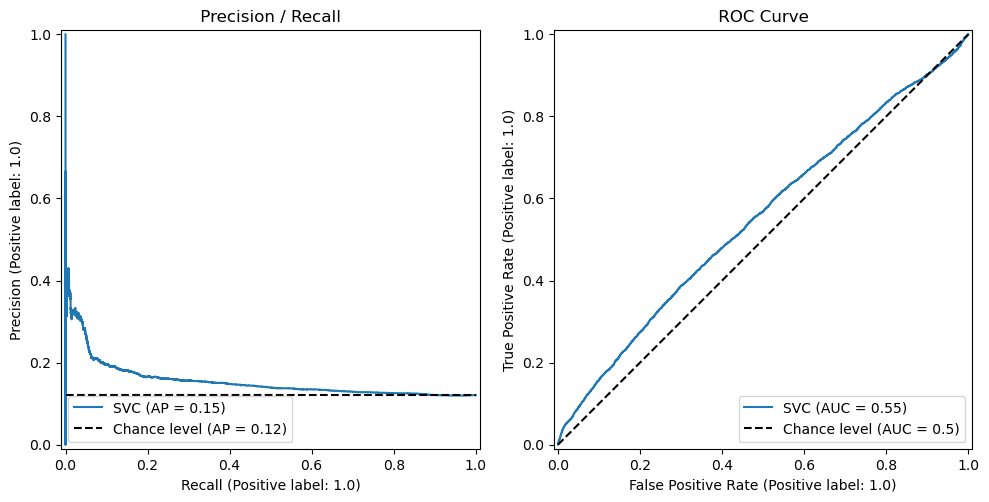

In [313]:
rows = 1
cols=2
fig, axs = plt.subplots(1, 2, sharey=False, tight_layout=True, figsize=(cols *5,5) )
_ = skm.PrecisionRecallDisplay.from_estimator(vt_svm.best_estimator_, test_X, test_y, plot_chance_level = True, ax = axs[0])
_ = skm.RocCurveDisplay.from_estimator(vt_svm.best_estimator_, test_X, test_y, plot_chance_level= True, ax = axs[1])
_ = axs[0].set_title(" Precision / Recall ")
_ = axs[1].set_title(" ROC Curve ")
plt.show()

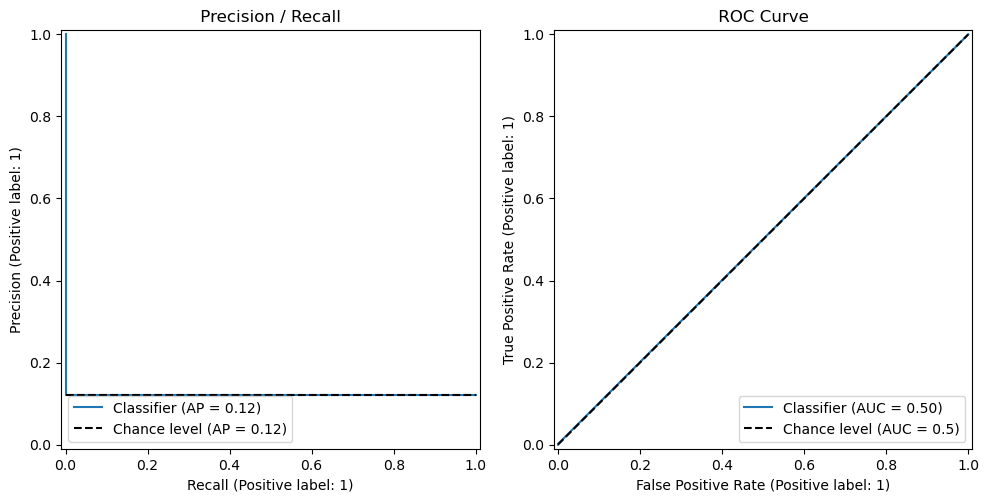

In [314]:
rows = 1
cols=2
fig, axs = plt.subplots(1, 2, sharey=False, tight_layout=True, figsize=(cols *5,5) )
_ = skm.PrecisionRecallDisplay.from_predictions(test_y, y_pred, plot_chance_level = True, ax = axs[0])
_ = skm.RocCurveDisplay.from_predictions(test_y, y_pred, plot_chance_level= True, ax = axs[1])
_ = axs[0].set_title(" Precision / Recall ")
_ = axs[1].set_title(" ROC Curve ")
plt.show()

# XGBoost Model - Param search using Optuna 

  #### Address for optuna dashboard repository:  `sqlite:////home/kevin/WSL-shared/Cellpainting/cj-datasets/optuna_database.db`

In [33]:
import sqlite3
import optuna
from KevinsRoutines.utils.utils_optuna import disp_study_history

In [34]:
db_path = "../cj-datasets/optuna_database.db"
storage_url = "sqlite:///../cj-datasets/optuna_database.db"

In [35]:
## https://optuna.readthedocs.io/en/stable/reference/generated/optuna.storages.RetryFailedTrialCallback.html
#
from optuna.storages import RetryFailedTrialCallback
#
optuna_storage = optuna.storages.RDBStorage(
    url=storage_url, 
    heartbeat_interval=60,
    grace_period=120,
    failed_trial_callback=RetryFailedTrialCallback(max_retry=3),
)

/tmp/ipykernel_3152734/1677463186.py:9: ExperimentalWarning: RetryFailedTrialCallback is experimental (supported from v2.8.0). The interface can change in the future.
  failed_trial_callback=RetryFailedTrialCallback(max_retry=3),


In [36]:
with sqlite3.connect(db_path) as conn:
    conn.row_factory = sqlite3.Row
    results = conn.execute("SELECT * FROM studies ;").fetchall()
    db_studies = [dict(r) for r in results]
    db_studies
# study_name = db_studies[-2]['study_name'] 


[{'study_id': 2, 'study_name': 'multiobjective-study-1'},
 {'study_id': 3, 'study_name': 'multiobjective-study-2'},
 {'study_id': 4, 'study_name': 'multiobjective-study-3'},
 {'study_id': 6, 'study_name': 'classification-study-Apr24'},
 {'study_id': 7, 'study_name': 'classification-3SampleStudy-Apr24'},
 {'study_id': 8, 'study_name': 'classification-study-1'},
 {'study_id': 9, 'study_name': 'embd_cls_XGB_base_bal_1:1'}]

In [37]:
# optuna.
# delete_study(study_name = 'embd_cls_XGB_base_imbal', storage=optuna_storage)
# resp = input(f" Delete study {study_name} ?")
# if resp.lower() in ['yes' ,'y']:
#     print(' You responsed yes')
#     try:
#         optuna.delete_study(storage=optuna_storage, study_name=study_name)
#         print("delete successful")
#     except Exception as e:
#         print("delete failed")
# else:
#     print(f" {study_name} will be kept")
study_name = 'embd_cls_XGB_base_bal_1:1'
study = optuna.create_study(storage=optuna_storage,
                            study_name=study_name,
                            directions=["maximize","minimize"], 
                            load_if_exists=True)
study.set_metric_names(["roc_auc", "logloss"])

[I 2024-08-08 06:52:24,482] Using an existing study with name 'embd_cls_XGB_base_bal_1:1' instead of creating a new one.
/tmp/ipykernel_3152734/607818156.py:18: ExperimentalWarning: set_metric_names is experimental (supported from v3.2.0). The interface can change in the future.
  study.set_metric_names(["roc_auc", "logloss"])


In [38]:
# study_name = 'embd_cls_XGB_base_imbal'
study_name = 'embd_cls_XGB_base_bal_1:1'
study  = optuna.load_study(study_name= study_name , storage=optuna_storage)


disp_study_history(study)

 embd_cls_XGB_base_bal_1:1  study history

                start     -   completion      status        validation metrics*
 trial#         time      -      time          code      roc_auc        logloss
--------------------------------------------------------------------------------
Trial #: 0    2024-08-08   01:22:12 - 01:22:12    3          *** FAILED ***        
Trial #: 1    2024-08-08   01:23:02 - 01:23:03    3          *** FAILED ***        
Trial #: 2    2024-08-08   01:24:19 - 01:25:02    3          *** FAILED ***        
Trial #: 3    2024-08-08   01:26:24 - 01:27:08    3          *** FAILED ***        
Trial #: 4    2024-08-08   01:28:20 - 01:29:04    3          *** FAILED ***        
Trial #: 5    2024-08-08   01:37:29 - 01:40:21    3          *** FAILED ***        
Trial #: 6    2024-08-08   01:56:32 - 01:57:24    3          *** FAILED ***        
 *** end of trials *** 
 Best trials:  []


In [44]:
def propose_parameters(trial, objective, eval_metric):
    _params = {
    ## General Parameters
    ## --------------------------------------------------------------            
    "verbosity"          : 0,
    # "objective"        :  "reg:squarederror",
    "objective"          :  objective,
    "eval_metric"        :  eval_metric,
    "booster"            :  "gbtree",   ## trial.suggest_categorical("booster", ["gbtree", "gblinear", "dart"]),
    
    ## Device     choices: 'cpu' . . . .
    "device"          : "gpu", 
    
    ## "validate_parameters" [default: True]
    
    ## nthread [default to maximum number of threads available if not set]
    ##                   Number of parallel threads used to run XGBoost. When choosing it, please keep thread contention
    ##                  and hyperthreading in mind.
    
    ## disable_default_eval_metric [default= false]  Flag to disable default metric. Set to 1 or true to disable.
    "n_estimators"     : trial.suggest_int("n_estimators", 50, 350, step = 100),
    
    ## Parameters for Tree Booster
    ## --------------------------------------------------------------
    
    ## tree_method:      [default="auto"] The tree construction algorithm used in XGBoost. 
    ##                   Choices: "auto", "exact", "approx", "hist", this is a combination of commonly used updaters. For other updaters like refresh, set the parameter updater directly.
    ##                             auto: Same as the hist tree method.
    ##                             exact: Exact greedy algorithm. Enumerates all split candidates.
    ##                             approx: Approximate greedy algorithm using quantile sketch and gradient histogram.
    ##                             hist: Faster histogram optimized approximate greedy algorithm.        
    "tree_method"        : "auto",
    
    ## ETA / learning_rate default =0.3 Step size shrinkage used in update to prevents overfitting. 
    ## After each boosting step, we can directly get the weights of new features, and eta shrinks the feature weights to make the boosting process more conservative.
    
    "learning_rate"    : trial.suggest_float("learning_rate", 0.001, 1000, log=True, step = None),
    # "learning_rate"    : trial.suggest_float("learning_rate", 0.0000001, 1, log=True, step = None),
    
     ## GAMMA / min_split_loss: Default=0. Minimum loss reduction required to make a further partition on a leaf node of the tree. 
    ##                    The larger gamma is, the more conservative the algorithm will be.
    ##                    range: [0, Inf) 
    # "min_split_loss"   : trial.suggest_float("min_split_loss", 0, 10),
    "gamma"            : trial.suggest_float("min_split_loss", 0, 10),
    
    ## max_depth:  [Default=6] Maximum depth of a tree. Increasing this value will make the model more complex and more likely to overfit. 
    ##             0 indicates no limit on depth. Beware that XGBoost aggressively consumes memory when training a deep tree. 
    ##             exact tree method requires non-zero value. 
    "max_depth"        : trial.suggest_int("max_depth", 1, 15),
    
    ## min_child_weight:  [default=1] Minimum sum of instance weight (hessian) needed in a child. 
    ##                    If the tree partition step results in a leaf node with the sum of instance weight less than min_child_weight, 
    ##                    then the building process will give up further partitioning. In linear regression task, this simply corresponds
    ##                    to minimum number of instances needed to be in each node. 
    ##                    The larger min_child_weight is, the more conservative the algorithm will be.
    ##                    range: [0,∞]        
    "min_child_weight"   : trial.suggest_float("min_child_weight", 0, 10),
    
    ## max_delta_step:    [default=0] Maximum delta step we allow each leaf output to be. 
    ##                    If the value is set to 0, it means there is no constraint. If it is set to a positive value, it can help making 
    ##                    the update step more conservative. Usually this parameter is not needed, but it might help in logistic regression 
    ##                    when class is extremely imbalanced. Set it to value of 1-10 might help control the update.
    ##                    range: [0,∞]        
    "max_delta_step"   : trial.suggest_float("max_delta_step", 0, 10),
    
    ## subsample [default=1]: Subsample ratio of the training instances. Setting it to 0.5 means that XGBoost would randomly sample half
    ##                       of the training data prior to growing trees. and this will prevent overfitting. Subsampling will occur once 
    ##                      in every boosting iteration.
    ##                      range: (0,1]
    "subsample"         : trial.suggest_float("subsample", 0.4, 1.0),
    
    ## sampling_method:  [default= uniform] The method to use to sample the training instances.
    ##              "uniform": each training instance has an equal probability of being selected. Typically set subsample >= 0.5 for good results.
    ##              "gradient_based": the selection probability for each training instance is proportional to the regularized absolute value of gradients 
    ##              (more specifically, SQRT(g^2 + lambda*h^2). subsample may be set to as low as 0.1 without loss of model accuracy. 
    ##              Note that this sampling method is only supported when tree_method is set to hist and the device is cuda; 
    ##              other tree methods only support uniform sampling.        
    "sampling_method"   : "uniform",
    
    ## NOTE:  All colsample_by* parameters have a range of (0, 1], the default value of 1
    ##        and specify the fraction of columns to be subsampled.
    
    ## colsample_bytree;  [default=1] is the subsample ratio of columns when constructing each tree. 
    ##                    Subsampling occurs once for every tree constructed.
    "colsample_bytree" : 1.0, ## trial.suggest_float("colsample_bytree", 0.5, 1),
    
    ## colsample_bylevel: [default=1] is the subsample ratio of columns for each level. Subsampling occurs once for every new depth level reached in a tree. 
    ##                    Columns are subsampled from the set of columns chosen for the current tree.
    "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.5, 1),
    
    ## colsample_bynode:  [default=1] the subsample ratio of columns for each node (split). Subsampling occurs once every time a new split is evaluated. 
    ##                    Columns are subsampled from the set of columns chosen for the current level.
    "colsample_bynode" : trial.suggest_float("colsample_bynode", 0.5, 1),
    
    # lambda [default=1, alias: reg_lambda]
    # L2 regularization term on weights. Increasing this value will make model more conservative.
    # range: [0, ∞]
    "lambda"           : 1,
    
    # alpha [default=0, alias: reg_alpha]
    # L1 regularization term on weights. Increasing this value will make model more conservative.        
    # range: [0, ∞]
    # "alpha"           : 0 
    
    ## scale_pos_weight [default=1] Control the balance of positive and negative weights, useful for unbalanced classes. 
    ##                 A typical value to consider: sum(negative instances) / sum(positive instances)        
    "scale_pos_weight" : 1,
            
    # tree_method string [default= auto] The tree construction algorithm used in XGBoost. See description in the reference paper and Tree Methods.
    #                  Choices: auto, exact, approx, hist, this is a combination of commonly used updaters. 
    #                           For other updaters like refresh, set the parameter updater directly.
    #                  auto:   Same as the hist tree method.
    #                  exact:  Exact greedy algorithm. Enumerates all split candidates`.
    #                  approx: Approximate greedy algorithm using quantile sketch and gradient histogram.
    #                  hist:   Faster histogram optimized approximate greedy algorithm.
    
    # updater
    # refresh_leaf [default=1]
    # process_type [default= default]
    
    # grow_policy [default= depthwise]
    
    # max_leaves [default=0] Maximum number of nodes to be added. Not used by exact tree method.
    "max_leaves"       : trial.suggest_int("max_leaves", 0, 6),
    # "max_leaves"       : 0, 
    
    # max_bin, [default=256]
    
    ## num_parallel_tree, [default=1]: Number of parallel trees constructed during each iteration. 
    ##                    This option is used to support boosted random forest.
    
    ## multi_strategy, [default = one_output_per_tree]
    ## max_cached_hist_node, [default = 65536]
    
    ## --------------------------------------------------------------
    ## Parameters for Categorical Features
    ## --------------------------------------------------------------
    ## These parameters are only used for training with categorical data. See Categorical Data for more information.
    ## Note: These parameters are experimental. exact tree method is not yet supported.
    ##
    ## max_cat_to_onehot:   A threshold for deciding whether XGBoost should use one-hot encoding based split for categorical data. 
    ##                      When number of categories is lesser than the threshold then one-hot encoding is chosen, otherwise the 
    ##                      categories will be partitioned into children nodes.
    ##                      New in version 1.6.0.
    # "max_cat_to_onehot": trial.suggest_int("max_cat_to_onehot", 1, 10),
    
    ## max_cat_threshold:  Maximum number of categories considered for each split. Used only by partition-based splits for preventing over-fitting.        
    ##                     New in version 1.7.0.
    
    
    ## --------------------------------------------------------------
    ## Learning Task Parameters
    ## --------------------------------------------------------------        
    
    
    
    ## SET STATIC ###############################################################################
    
    ## lambda [default=1, alias: reg_lambda]  L2 regularization term on weights. Increasing this value will make model more conservative.
    ##                    range: [0, Inf) 
    # "reg_lambda"       : trial.suggest_float("reg_lambda", 0, 10),
    "reg_lambda"       : 3.2267,   
    
    }    
    return _params


In [70]:
def train_model(iter_files, X,  y , metric_keys = None, eval_keys = None, study_name = "", trial_num = 0, save = False, 
                **model_params):
    metrics_hist = defaultdict(list)
    my_model = None
    
    for i, (trn_idxs, val_idxs) in enumerate(iter_files):
        logging.info(f"CrossValidation split #{i}")
        logging.info(f"Building training & validation DMatrix...")
        X_train, y_train = X[trn_idxs], y[trn_idxs]
        X_val, y_val = X[val_idxs], y[val_idxs]
        
        logging.info(f"Training model...")
        # booster_model = my_model['booster'] if my_model is not None else None
        my_model = xgb.XGBClassifier( nthread = 2, verbose_eval = True,
                                      **model_params)
        # my_model = xgb.dask.train(None, model_params, d_train, gb_model = booster_model, num_boost_round=1000, evals=[(d_train, "train"), (d_val, "test")],
        #                           verbose_eval=False, early_stopping_rounds = 50 )
        my_model.fit(X_train,
                y_train,
                eval_set=[(X_train, y_train), (X_val, y_val)],
                verbose=True,
                )
        # logging.info(f"Training model...Completed")
        
        logging.info(f"Running model on test data...")
        y_pred = my_model.predict(X_val)   
        y_true = y_val.squeeze()

        # Compute predictions and mean squared error for this iteration
        logging.info(f"Calculating metrics...")
        iter_metrics = compute_classification_metrics(my_model, y_true, y_pred, top_k = 2, mode = 'val')
        logging.info(f"Calculating metrics...Completed")
        
        print("-" * 80)            
        for key in metric_keys:
            metrics_hist[key].append(iter_metrics[key])
            print(f" {key:20s}: {iter_metrics[key]:9.5f}")
        print("-" * 80)            
        # Load evals result by calling the evals_result() function

        del  X_train, y_train, X_val, y_val, y_true, y_pred

    ## End of loop  
    return my_model, metrics_hist

In [71]:
def objective(trial, disp_params = True, save = True):
    eval_keys = ["train_auc", "train_logloss", "val_auc", "val_logloss"]
    metric_keys = [ "train_auc", "train_logloss", "val_auc", "val_logloss", "roc_auc", "logloss", "accuracy","bal_acc","top_k_acc","F1_score","map","pearson_corr"]    
    CV_FOLDS = 5
    obj = "binary:logistic"
    eval_metric =["auc", "logloss"]
    # eval_metric ="auc"
    
    study_params = propose_parameters(trial, obj, eval_metric)   
    study_params = {"booster"      : "gbtree",
                    "device"       : "gpu",
                    # "objective"    :  "binary:logistic",
                    # "eval_metric"  :  ["auc", "logloss"],
                    "verbosity"    : 0, 
                    "disable_default_eval_metric" : False,
                    ** study_params}
    print('-'*80)
    print(f" Training model (trial #{trial.number}) ")
    print('-'*80)

    if disp_params:
        print(f" Parameters:")
        for k, v in study_params.items():
            print(f"  {k:30s} {v}")
            
    # iter_files = make_cv_splits_2(input_file_list, n_folds=CV_FOLDS, y_columns=y_columns)
    sgkf = StratifiedGroupKFold(n_splits = 5,)
    iter_files = sgkf.split(X_DATA, Y_DATA, GRP_DATA)
    model, metrics =  train_model(iter_files,
                                  X = X_DATA, 
                                  y = Y_DATA, 
                                  metric_keys = metric_keys, 
                                  eval_keys = eval_keys,
                                  study_name = study.study_name,
                                  trial_num = trial.number,
                                  save = True,
                                  ** study_params)

    print_metric_hist(metrics)
    model_booster = model.get_booster()
    print(f" model best score    :  {model_booster.best_score}")
    print(f" model best iteration:  {model_booster.best_iteration}")
    
    if save:
        save_as_filename = "./saved_models/{0}_trial_{1:03d}.json".format(study.study_name,trial.number)
        print(f" Save model to : {save_as_filename}")
        model_booster.save_model(save_as_filename)    

    r1 = np.array(metrics['val_auc']).mean()
    r2 = np.array(metrics['val_logloss']).mean()
    del model, metrics 
    return r1,r2 

In [72]:
# PARM_SET = xgb_grid_parameters_3
# sgkf = StratifiedGroupKFold(n_splits = 5,)
# NUM_JOBS = 5
# X_DATA, Y_DATA, GRP_DATA = bal_train_X, bal_train_y, bal_grouping_xy
X_DATA, Y_DATA, GRP_DATA = train_X, train_y, grouping_xy
# CV_SCHEME = sgkf.split(X_DATA, Y_DATA, GRP_DATA)

## Run studies

In [73]:
start = datetime.now()

study.optimize(objective, n_trials=1, timeout=3600*7, gc_after_trial=True, show_progress_bar=True)

print(f"Total time:  {datetime.now() - start}")

  0%|          | 0/1 [00:00<?, ?it/s]

/home/kevin/miniforge3/envs/cp311/lib/python3.11/site-packages/optuna/study/_optimize.py:189: ExperimentalWarning: fail_stale_trials is experimental (supported from v2.9.0). The interface can change in the future.
  optuna.storages.fail_stale_trials(study)


--------------------------------------------------------------------------------
 Training model (trial #15) 
--------------------------------------------------------------------------------
 Parameters:
  booster                        gbtree
  device                         gpu
  verbosity                      0
  disable_default_eval_metric    False
  objective                      binary:logistic
  eval_metric                    ['auc', 'logloss']
  n_estimators                   50
  tree_method                    auto
  learning_rate                  98.27202877366454
  gamma                          1.9103749084237376
  max_depth                      3
  min_child_weight               9.202774173453792
  max_delta_step                 4.3927509553052175
  subsample                      0.9100178204658589
  sampling_method                uniform
  colsample_bytree               1.0
  colsample_bylevel              0.64832576495897
  colsample_bynode               0.76001989820246

2024-08-08 18:28:42,517 - root - INFO: - CrossValidation split #0
2024-08-08 18:28:42,520 - root - INFO: - Building training & validation DMatrix...
2024-08-08 18:28:42,778 - root - INFO: - Training model...


[0]	validation_0-auc:0.54662	validation_0-logloss:4.39664	validation_1-auc:0.54683	validation_1-logloss:4.40917
[1]	validation_0-auc:0.54662	validation_0-logloss:4.39664	validation_1-auc:0.54683	validation_1-logloss:4.40917
[2]	validation_0-auc:0.54662	validation_0-logloss:4.39664	validation_1-auc:0.54683	validation_1-logloss:4.40917
[3]	validation_0-auc:0.54662	validation_0-logloss:4.39664	validation_1-auc:0.54683	validation_1-logloss:4.40917
[4]	validation_0-auc:0.54662	validation_0-logloss:4.39664	validation_1-auc:0.54683	validation_1-logloss:4.40917
[5]	validation_0-auc:0.54662	validation_0-logloss:4.39664	validation_1-auc:0.54683	validation_1-logloss:4.40917
[6]	validation_0-auc:0.54662	validation_0-logloss:4.39664	validation_1-auc:0.54683	validation_1-logloss:4.40917
[7]	validation_0-auc:0.54662	validation_0-logloss:4.39664	validation_1-auc:0.54683	validation_1-logloss:4.40917
[8]	validation_0-auc:0.54662	validation_0-logloss:4.39664	validation_1-auc:0.54683	validation_1-logloss:

2024-08-08 18:28:44,755 - root - INFO: - Running model on test data...
2024-08-08 18:28:44,912 - root - INFO: - Calculating metrics...
/home/kevin/miniforge3/envs/cp311/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:1970: UndefinedMetricWarning: 'k' (2) greater than or equal to 'n_classes' (2) will result in a perfect score and is therefore meaningless.
  warnings.warn(
2024-08-08 18:28:44,981 - root - INFO: - Calculating metrics...Completed
2024-08-08 18:28:45,052 - root - INFO: - CrossValidation split #1
2024-08-08 18:28:45,053 - root - INFO: - Building training & validation DMatrix...


--------------------------------------------------------------------------------
 train_auc           :   0.54662
 train_logloss       :   4.39664
 val_auc             :   0.54683
 val_logloss         :   4.39664
 roc_auc             :   0.52052
 logloss             :   5.49146
 accuracy            :   0.84764
 bal_acc             :   0.04104
 top_k_acc           :   1.00000
 F1_score            :   0.12467
 map                 :   0.12628
 pearson_corr        :   0.05835
--------------------------------------------------------------------------------


2024-08-08 18:28:45,364 - root - INFO: - Training model...


[0]	validation_0-auc:0.54426	validation_0-logloss:4.59289	validation_1-auc:0.54461	validation_1-logloss:4.59091
[1]	validation_0-auc:0.50000	validation_0-logloss:32.45317	validation_1-auc:0.50000	validation_1-logloss:32.45228
[2]	validation_0-auc:0.50000	validation_0-logloss:32.45317	validation_1-auc:0.50000	validation_1-logloss:32.45228
[3]	validation_0-auc:0.50000	validation_0-logloss:32.45317	validation_1-auc:0.50000	validation_1-logloss:32.45228
[4]	validation_0-auc:0.50000	validation_0-logloss:32.45317	validation_1-auc:0.50000	validation_1-logloss:32.45228
[5]	validation_0-auc:0.50000	validation_0-logloss:32.45317	validation_1-auc:0.50000	validation_1-logloss:32.45228
[6]	validation_0-auc:0.50000	validation_0-logloss:32.45317	validation_1-auc:0.50000	validation_1-logloss:32.45228
[7]	validation_0-auc:0.50000	validation_0-logloss:32.45317	validation_1-auc:0.50000	validation_1-logloss:32.45228
[8]	validation_0-auc:0.50000	validation_0-logloss:32.45317	validation_1-auc:0.50000	valida

2024-08-08 18:28:47,249 - root - INFO: - Running model on test data...
2024-08-08 18:28:47,418 - root - INFO: - Calculating metrics...
/home/kevin/miniforge3/envs/cp311/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:1970: UndefinedMetricWarning: 'k' (2) greater than or equal to 'n_classes' (2) will result in a perfect score and is therefore meaningless.
  warnings.warn(
/home/kevin/miniforge3/envs/cp311/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
2024-08-08 18:28:47,487 - root - INFO: - Calculating metrics...Completed
2024-08-08 18:28:47,563 - root - INFO: - CrossValidation split #2
2024-08-08 18:28:47,563 - root - INFO: - Building training & validation DMatrix...


--------------------------------------------------------------------------------
 train_auc           :   0.50000
 train_logloss       :  32.45317
 val_auc             :   0.50000
 val_logloss         :  32.45317
 roc_auc             :   0.50000
 logloss             :  31.74961
 accuracy            :   0.11913
 bal_acc             :   0.00000
 top_k_acc           :   1.00000
 F1_score            :   0.21290
 map                 :   0.11913
 pearson_corr        :       nan
--------------------------------------------------------------------------------


2024-08-08 18:28:47,981 - root - INFO: - Training model...


[0]	validation_0-auc:0.54402	validation_0-logloss:4.17613	validation_1-auc:0.54629	validation_1-logloss:4.18735
[1]	validation_0-auc:0.50000	validation_0-logloss:32.45272	validation_1-auc:0.50000	validation_1-logloss:32.45405
[2]	validation_0-auc:0.50000	validation_0-logloss:32.45272	validation_1-auc:0.50000	validation_1-logloss:32.45405
[3]	validation_0-auc:0.50000	validation_0-logloss:32.45272	validation_1-auc:0.50000	validation_1-logloss:32.45405
[4]	validation_0-auc:0.50000	validation_0-logloss:32.45272	validation_1-auc:0.50000	validation_1-logloss:32.45405
[5]	validation_0-auc:0.50000	validation_0-logloss:32.45272	validation_1-auc:0.50000	validation_1-logloss:32.45405
[6]	validation_0-auc:0.50000	validation_0-logloss:32.45272	validation_1-auc:0.50000	validation_1-logloss:32.45405
[7]	validation_0-auc:0.50000	validation_0-logloss:32.45272	validation_1-auc:0.50000	validation_1-logloss:32.45405
[8]	validation_0-auc:0.50000	validation_0-logloss:32.45272	validation_1-auc:0.50000	valida

2024-08-08 18:28:49,879 - root - INFO: - Running model on test data...
2024-08-08 18:28:50,056 - root - INFO: - Calculating metrics...
/home/kevin/miniforge3/envs/cp311/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:1970: UndefinedMetricWarning: 'k' (2) greater than or equal to 'n_classes' (2) will result in a perfect score and is therefore meaningless.
  warnings.warn(
/home/kevin/miniforge3/envs/cp311/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
2024-08-08 18:28:50,114 - root - INFO: - Calculating metrics...Completed
2024-08-08 18:28:50,180 - root - INFO: - CrossValidation split #3
2024-08-08 18:28:50,181 - root - INFO: - Building training & validation DMatrix...


--------------------------------------------------------------------------------
 train_auc           :   0.50000
 train_logloss       :  32.45272
 val_auc             :   0.50000
 val_logloss         :  32.45272
 roc_auc             :   0.50000
 logloss             :  31.75134
 accuracy            :   0.11909
 bal_acc             :   0.00000
 top_k_acc           :   1.00000
 F1_score            :   0.21283
 map                 :   0.11909
 pearson_corr        :       nan
--------------------------------------------------------------------------------


2024-08-08 18:28:50,487 - root - INFO: - Training model...


[0]	validation_0-auc:0.54743	validation_0-logloss:4.95709	validation_1-auc:0.53560	validation_1-logloss:5.01213
[1]	validation_0-auc:0.54743	validation_0-logloss:4.95709	validation_1-auc:0.53560	validation_1-logloss:5.01213
[2]	validation_0-auc:0.54743	validation_0-logloss:4.95709	validation_1-auc:0.53560	validation_1-logloss:5.01213
[3]	validation_0-auc:0.54743	validation_0-logloss:4.95709	validation_1-auc:0.53560	validation_1-logloss:5.01213
[4]	validation_0-auc:0.54743	validation_0-logloss:4.95709	validation_1-auc:0.53560	validation_1-logloss:5.01213
[5]	validation_0-auc:0.54743	validation_0-logloss:4.95709	validation_1-auc:0.53560	validation_1-logloss:5.01213
[6]	validation_0-auc:0.54743	validation_0-logloss:4.95709	validation_1-auc:0.53560	validation_1-logloss:5.01213
[7]	validation_0-auc:0.54743	validation_0-logloss:4.95709	validation_1-auc:0.53560	validation_1-logloss:5.01213
[8]	validation_0-auc:0.54743	validation_0-logloss:4.95709	validation_1-auc:0.53560	validation_1-logloss:

2024-08-08 18:28:52,360 - root - INFO: - Running model on test data...
2024-08-08 18:28:52,512 - root - INFO: - Calculating metrics...
/home/kevin/miniforge3/envs/cp311/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:1970: UndefinedMetricWarning: 'k' (2) greater than or equal to 'n_classes' (2) will result in a perfect score and is therefore meaningless.
  warnings.warn(
2024-08-08 18:28:52,572 - root - INFO: - Calculating metrics...Completed
2024-08-08 18:28:52,639 - root - INFO: - CrossValidation split #4
2024-08-08 18:28:52,640 - root - INFO: - Building training & validation DMatrix...


--------------------------------------------------------------------------------
 train_auc           :   0.54743
 train_logloss       :   4.95709
 val_auc             :   0.53560
 val_logloss         :   4.95709
 roc_auc             :   0.51330
 logloss             :   5.08828
 accuracy            :   0.85883
 bal_acc             :   0.02660
 top_k_acc           :   1.00000
 F1_score            :   0.09157
 map                 :   0.12368
 pearson_corr        :   0.04606
--------------------------------------------------------------------------------


2024-08-08 18:28:53,152 - root - INFO: - Training model...


[0]	validation_0-auc:0.54509	validation_0-logloss:4.83774	validation_1-auc:0.54028	validation_1-logloss:4.85490
[1]	validation_0-auc:0.54509	validation_0-logloss:4.83774	validation_1-auc:0.54028	validation_1-logloss:4.85490
[2]	validation_0-auc:0.54509	validation_0-logloss:4.83774	validation_1-auc:0.54028	validation_1-logloss:4.85490
[3]	validation_0-auc:0.54509	validation_0-logloss:4.83774	validation_1-auc:0.54028	validation_1-logloss:4.85490
[4]	validation_0-auc:0.54509	validation_0-logloss:4.83774	validation_1-auc:0.54028	validation_1-logloss:4.85490
[5]	validation_0-auc:0.54509	validation_0-logloss:4.83774	validation_1-auc:0.54028	validation_1-logloss:4.85490
[6]	validation_0-auc:0.54509	validation_0-logloss:4.83774	validation_1-auc:0.54028	validation_1-logloss:4.85490
[7]	validation_0-auc:0.54509	validation_0-logloss:4.83774	validation_1-auc:0.54028	validation_1-logloss:4.85490
[8]	validation_0-auc:0.54509	validation_0-logloss:4.83774	validation_1-auc:0.54028	validation_1-logloss:

2024-08-08 18:28:55,032 - root - INFO: - Running model on test data...
2024-08-08 18:28:55,185 - root - INFO: - Calculating metrics...
/home/kevin/miniforge3/envs/cp311/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:1970: UndefinedMetricWarning: 'k' (2) greater than or equal to 'n_classes' (2) will result in a perfect score and is therefore meaningless.
  warnings.warn(
2024-08-08 18:28:55,247 - root - INFO: - Calculating metrics...Completed


--------------------------------------------------------------------------------
 train_auc           :   0.54509
 train_logloss       :   4.83774
 val_auc             :   0.54028
 val_logloss         :   4.83774
 roc_auc             :   0.51506
 logloss             :   5.08481
 accuracy            :   0.85893
 bal_acc             :   0.03011
 top_k_acc           :   1.00000
 F1_score            :   0.09704
 map                 :   0.12455
 pearson_corr        :   0.05162
--------------------------------------------------------------------------------
[W 2024-08-08 18:28:55,324] Trial 15 failed with parameters: {'n_estimators': 50, 'learning_rate': 98.27202877366454, 'min_split_loss': 1.9103749084237376, 'max_depth': 3, 'min_child_weight': 9.202774173453792, 'max_delta_step': 4.3927509553052175, 'subsample': 0.9100178204658589, 'colsample_bylevel': 0.64832576495897, 'colsample_bynode': 0.760019898202464, 'max_leaves': 6} because of the following error: NameError("name 'print_metric_his

NameError: name 'print_metric_hist' is not defined